POINT TO NOTE-> 1) I HAD UPLAODED THE DATASET DIRECTLY ON MY GOOGLE DRIVE AND ACCESSING THE DATA FROM THERE ONLY SO IF YOU DONT HAVE THE DATA FILE ON GOOGLE DRIVE UPLOAD IT THERE OR EITHER UPLOAD IT ON THE NOTEBOOK BUT CHANGE THE PATH

# Q1)->.
Common Task 1. Auto-encoder of the quark/gluon events

Please train a variational auto-encoder to learn the representation based on three image channels (ECAL, HCAL and Tracks) for the dataset.

Please show a side-by-side comparison of original and reconstructed events.


In [ ]:
!pip install numpy==1.23.5
!pip install tensorflow==2.12.0
!pip install matplotlib==3.7.1 scikit-learn==1.2.2 pandas h5py
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.0.1+cu118.html



Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
from sklearn.model_selection import train_test_split
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from google.colab import drive
try:
    drive.mount('/content/drive', force_remount=True)
    print("Drive mounted successfully")
except Exception as e:
    print(f"Error mounting drive: {str(e)}")

# Set random seeds for reproducibility
import numpy as np
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)


class ConvVariationalAutoencoder(nn.Module):
    def __init__(self, in_channels=3, latent_dim=32, input_size=(125, 125)):
        super(ConvVariationalAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=4, stride=2, padding=1),  # 125x125 -> 63x63
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 63x63 -> 32x32
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 16x16 -> 8x8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 8x8 -> 4x4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
        )

        # Calculate the output size after encoder
        self.encoder_output_size = self._get_encoder_output_size(in_channels, input_size)
        self.flatten_size = np.prod(self.encoder_output_size)

        # Latent space projection
        self.fc_mu = nn.Linear(self.flatten_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_size, latent_dim)

        # Decoder input layer
        self.decoder_input = nn.Linear(latent_dim, self.flatten_size)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 4x4 -> 8x8
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 8x8 -> 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 16x16 -> 32x32
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 32x32 -> 64x64
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, in_channels, kernel_size=4, stride=2, padding=1),  # 64x64 -> 128x128
            nn.Sigmoid()
        )

    def _get_encoder_output_size(self, in_channels, input_size):
        """Calculate encoder output size without using a dummy tensor (memory efficient)"""
        # Manual calculation of the output size after 5 layers of stride 2 convolutions
        h, w = input_size
        for _ in range(5):  # 5 conv layers with stride 2
            h = (h + 2*1 - 4) // 2 + 1
            w = (w + 2*1 - 4) // 2 + 1
        return (512, h, w)  # 512 is the number of channels in the last encoder layer

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten
        mu = self.fc_mu(x)
        log_var = self.fc_logvar(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        # Clip log_var for numerical stability
        log_var = torch.clamp(log_var, min=-20, max=20)
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(x.size(0), *self.encoder_output_size)
        x = self.decoder(x)
        # Resize to match original dimensions (125x125)
        x = F.interpolate(x, size=(125, 125), mode='bilinear', align_corners=False)
        return x

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        reconstruction = self.decode(z)
        return reconstruction, mu, log_var



def kl_divergence_loss(mu, log_var):
    """
    Compute KL divergence loss
    """
    # KL divergence: -0.5 * sum(1 + log_var - mu^2 - exp(log_var))
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return kl_loss

def vae_loss(reconstruction, original, mu, log_var, kl_weight=0.001):
    """
    Physics-aware VAE loss that gives higher importance to high-energy deposits
    """
    # Create importance weighting matrix - give more weight to high-energy deposits
    importance_weights = 1.0 + original * 4.0  # Pixels with energy get 1-5x more importance

    # Weighted MSE loss
    diff_squared = (reconstruction - original) ** 2
    weighted_diff = diff_squared * importance_weights
    reconstruction_loss = torch.sum(weighted_diff)

    # KL divergence with numerical stability improvements
    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    # Ensure KL divergence is not NaN or Inf
    if torch.isnan(kl_div) or torch.isinf(kl_div):
        print("Warning: KL divergence is NaN or Inf, using zero instead")
        kl_div = torch.tensor(0.0, device=reconstruction.device)

    # Total loss
    total_loss = reconstruction_loss + kl_weight * kl_div

    return total_loss, reconstruction_loss, kl_div

def load_jet_data(file_path='jets_data.h5'):
    """Load the jet dataset"""
    with h5py.File(file_path, 'r') as f:
        X_jets = f['X_jets'][:]  # Shape (N, 125, 125, 3)
        y = f['y'][:]            # Labels
        m0 = f['m0'][:]          # Jet mass (if available)
        pt = f['pt'][:]          # Transverse momentum (if available)

    print(f"Data shape: {X_jets.shape}")
    print(f"Labels shape: {y.shape}")
    return X_jets, y, m0, pt
def preprocess_data(X_jets, max_samples=10000):
    """
    Preprocess jet data with physics-aware normalization to preserve high-energy features.
    """
    # Limit samples to process
    n_samples = min(max_samples, X_jets.shape[0])
    X_jets_subset = X_jets[:n_samples]

    # Transpose to PyTorch's expected format (N, C, H, W)
    X_jets_transposed = np.transpose(X_jets_subset, (0, 3, 1, 2))

    # Initialize output array
    normalized_data = np.zeros_like(X_jets_transposed, dtype=np.float32)

    # Store normalization parameters for each channel
    scale_factors = []

    for c in range(X_jets_transposed.shape[1]):
        channel_data = X_jets_transposed[:, c, :, :]

        # Use a combination of linear and log scaling
        # For energy deposits (assuming channel 0 is energy)
        if c == 0:  # Energy channel
            # Add small constant to avoid log(0)
            eps = 1e-8
            # Apply softer log transform to preserve more of the high-energy structure
            transformed_data = np.log1p(channel_data * 10 + eps) / 3.0  # Adjust multiplier for sensitivity

            # Get scaling factors using non-zero values only
            non_zero_mask = channel_data > 0
            if np.any(non_zero_mask):
                p_low, p_high = np.percentile(transformed_data[non_zero_mask], [1, 99.9])
            else:
                p_low, p_high = 0, 1

            # Ensure reasonable scale
            scale = p_high - p_low
            if scale < 1e-10:
                p_low = 0
                p_high = 1.0
                scale = 1.0

            # Apply normalization
            normalized_channel = (transformed_data - p_low) / scale

            # Special handling: keep high-energy deposits (important features) emphasized
            # This is key for preserving the yellow regions
            high_energy_mask = normalized_channel > 0.75  # Threshold for high-energy deposits
            normalized_channel[high_energy_mask] = 0.75 + (normalized_channel[high_energy_mask] - 0.75) * 1.5

            # Store transform type for later denormalization
            transform_type = "energy_log"
        else:
            # Other channels (like angles, etc.) - use standard scaling
            if np.std(channel_data) > 1e-10:
                mean, std = np.mean(channel_data), np.std(channel_data)
                normalized_channel = (channel_data - mean) / (3 * std)  # 3*std to keep most values in [0,1]
                normalized_channel = np.clip(normalized_channel, -1, 1) * 0.5 + 0.5  # Rescale to [0,1]
                p_low, scale = mean, 3 * std
                transform_type = "standard"
            else:
                normalized_channel = channel_data
                p_low, scale = 0, 1
                transform_type = "identity"

        # Store the normalized data
        normalized_data[:, c, :, :] = normalized_channel

        # Store scaling parameters
        scale_factors.append((p_low, scale, transform_type))

    # Final sanity check
    normalized_data = np.clip(normalized_data, 0, 1)
    normalized_data = np.nan_to_num(normalized_data)

    print(f"Preprocessed data shape: {normalized_data.shape}")
    print(f"Data range: [{np.min(normalized_data)}, {np.max(normalized_data)}]")

    return normalized_data, scale_factors

def denormalize_data(normalized_data, scale_factors):
    """
    Reconstruct the original data scale from normalized data.
    This is crucial for proper evaluation and visualization.
    """
    denormalized_data = np.zeros_like(normalized_data, dtype=np.float32)

    for c in range(normalized_data.shape[1]):
        p_low, scale, transform_type = scale_factors[c]

        if transform_type == "log":
            # First undo the normalization
            log_data = normalized_data[:, c, :, :] * scale + p_low
            # Then undo the log transform
            denormalized_data[:, c, :, :] = np.expm1(log_data)  # exp(x) - 1
        else:
            # Linear scaling
            denormalized_data[:, c, :, :] = normalized_data[:, c, :, :] * scale + p_low

    return denormalized_data

def visualize_reconstruction(original_batch, reconstructed_batch, sample_indices, save_dir='.', filename_prefix=''):
    """Visualize reconstructions with improved formatting and error handling"""
    os.makedirs(save_dir, exist_ok=True)

    # Channel names for better visualization
    channel_names = ['ECAL', 'HCAL', 'Tracks']

    for idx in sample_indices:
        if idx >= original_batch.shape[0]:
            continue

        try:
            # Get original and reconstructed images
            orig_img = original_batch[idx].cpu().numpy()
            recon_img = reconstructed_batch[idx].detach().cpu().numpy()

            # Create figure with subplots for each channel
            fig, axes = plt.subplots(3, 2, figsize=(12, 18))
            fig.suptitle(f'Jet Event {idx} - Original vs. Reconstructed', fontsize=16)

            # For each channel
            for c in range(3):
                # Set vmin and vmax the same for both original and reconstruction
                vmin = min(np.min(orig_img[c]), np.min(recon_img[c]))
                vmax = max(np.max(orig_img[c]), np.max(recon_img[c]))

                # Original image
                im1 = axes[c, 0].imshow(orig_img[c], cmap='viridis', vmin=vmin, vmax=vmax)
                axes[c, 0].set_title(f'Original - {channel_names[c]}')
                axes[c, 0].axis('off')
                fig.colorbar(im1, ax=axes[c, 0], fraction=0.046, pad=0.04)

                # Reconstructed image
                im2 = axes[c, 1].imshow(recon_img[c], cmap='viridis', vmin=vmin, vmax=vmax)
                axes[c, 1].set_title(f'Reconstructed - {channel_names[c]}')
                axes[c, 1].axis('off')
                fig.colorbar(im2, ax=axes[c, 1], fraction=0.046, pad=0.04)

            plt.tight_layout()
            plt.savefig(f'{save_dir}/{filename_prefix}vae_reconstruction_sample_{idx}.png')
            plt.close(fig)
        except Exception as e:
            print(f"Error visualizing sample {idx}: {e}")

def evaluate_reconstruction(original_batch, reconstructed_batch):
    """Calculate reconstruction metrics with improved error handling"""
    try:
        # Convert to numpy for calculation
        orig = original_batch.cpu().numpy()
        recon = reconstructed_batch.detach().cpu().numpy()

        # Mean Squared Error
        mse = np.mean((orig - recon) ** 2)

        # Mean Absolute Error
        mae = np.mean(np.abs(orig - recon))

        # Root Mean Squared Error
        rmse = np.sqrt(mse)

        # Normalized RMSE
        data_range = np.max(orig) - np.min(orig)
        nrmse = rmse / data_range if data_range > 1e-10 else rmse

        # Peak Signal-to-Noise Ratio
        if mse > 1e-10:
            psnr = 20 * np.log10(1.0 / np.sqrt(mse))
        else:
            psnr = 100  # High value for very good reconstruction

        return {
            'MSE': mse,
            'MAE': mae,
            'RMSE': rmse,
            'NRMSE': nrmse,
            'PSNR': psnr
        }
    except Exception as e:
        print(f"Error calculating metrics: {e}")
        return {
            'MSE': float('nan'),
            'MAE': float('nan'),
            'RMSE': float('nan'),
            'NRMSE': float('nan'),
            'PSNR': float('nan')
        }

def plot_training_curves(train_losses, val_losses, recon_losses, kl_losses, save_path='vae_training_history.png'):
    """Plot training curves with better error handling and formatting"""
    try:
        # Filter out any NaN or Inf values
        train_losses = [x for x in train_losses if not (np.isnan(x) or np.isinf(x))]
        val_losses = [x for x in val_losses if not (np.isnan(x) or np.isinf(x))]
        recon_losses = [x for x in recon_losses if not (np.isnan(x) or np.isinf(x))]
        kl_losses = [x for x in kl_losses if not (np.isnan(x) or np.isinf(x))]

        plt.figure(figsize=(15, 7))

        # Plot total losses
        plt.subplot(1, 2, 1)
        if train_losses:
            plt.plot(train_losses, 'b-', label='Train Loss')
        if val_losses:
            plt.plot(val_losses, 'r-', label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Plot component losses
        plt.subplot(1, 2, 2)
        if recon_losses:
            plt.plot(recon_losses, 'g-', label='Reconstruction Loss')
        if kl_losses:
            plt.plot(kl_losses, 'm-', label='KL Divergence Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Component Losses')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(save_path)
        plt.close()
    except Exception as e:
        print(f"Error plotting training curves: {e}")



def train_vae(X_jets, batch_size=16, epochs=10, latent_dim=16, learning_rate=0.0005, max_samples=10000, save_dir='vae_results'):
    """Train a Variational Autoencoder with memory optimizations and stability improvements"""

    # Create save directory
    os.makedirs(save_dir, exist_ok=True)

    # 1. Preprocess the data (with reduced max_samples)
    X_processed, normalization_factors = preprocess_data(X_jets, max_samples)

    # 2. Convert to PyTorch tensors
    X_tensor = torch.tensor(X_processed, dtype=torch.float32)

    # 3. Split dataset into train and validation
    X_train, X_val = train_test_split(X_tensor, test_size=0.2, random_state=42)

    print(f"Training data shape: {X_train.shape}")
    print(f"Validation data shape: {X_val.shape}")

    # 4. Create data loaders with smaller batch size
    train_dataset = TensorDataset(X_train)
    val_dataset = TensorDataset(X_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # 5. Initialize model, optimizer and loss function
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Use smaller latent dimension and weight decay
    model = ConvVariationalAutoencoder(in_channels=3, latent_dim=latent_dim).to(device)

    # Print model summary
    print(f"VAE Model with latent dimension: {latent_dim}")
    print(f"Encoder output size: {model.encoder_output_size}")
    print(f"Flattened size: {model.flatten_size}")

    # Use Adam optimizer with lower learning rate and weight decay
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    # Learning rate scheduler with more patience
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.7, patience=5, verbose=True, min_lr=1e-6
    )

    # 6. Training loop with progress tracking
    train_losses = []
    val_losses = []
    recon_losses = []
    kl_losses = []

    # Early stopping setup
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    # KL annealing schedule - gradually increase KL weight from 0 to max_kl_weight
    max_kl_weight = 0.01

    # Save initial random samples for comparison later
    if len(val_loader) > 0:
        x_samples = next(iter(val_loader))[0].to(device)[:5]  # Take first 5 samples
        visualize_reconstruction(x_samples, x_samples, list(range(5)),
                                save_dir=save_dir, filename_prefix='initial_')

    for epoch in range(epochs):
        # Training
        model.train()
        epoch_loss = 0.0
        epoch_recon_loss = 0.0
        epoch_kl_loss = 0.0
        batch_count = 0

        # KL annealing - gradually increase weight
        kl_weight = min(max_kl_weight, (epoch + 1) / (epochs / 2) * max_kl_weight)

        # Initialize progress bar for training
        train_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")

        for batch in train_iterator:
            x = batch[0].to(device)

            # Forward pass
            reconstructed, mu, log_var = model(x)

            # Calculate loss
            loss, recon_loss, kl_loss = vae_loss(reconstructed, x, mu, log_var, kl_weight=kl_weight)

            # Skip backward pass if loss is NaN or Inf
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"Warning: Loss is {loss.item()}, skipping batch")
                continue

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Backward pass and optimize
            loss.backward()

            # Gradient clipping (reduced max_norm)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)

            optimizer.step()

            # Update metrics
            epoch_loss += loss.item()
            epoch_recon_loss += recon_loss.item()
            epoch_kl_loss += kl_loss.item()
            batch_count += 1

            # Update progress bar
            train_iterator.set_postfix({
                "loss": loss.item() / x.size(0),
                "recon": recon_loss.item() / x.size(0),
                "kl": kl_loss.item() / x.size(0),
                "kl_w": kl_weight
            })

            # Clear cache periodically to avoid OOM
            if batch_count % 10 == 0:
                torch.cuda.empty_cache()

        # Average losses for the epoch (handle case where batch_count is 0)
        if batch_count > 0:
            train_loss = epoch_loss / (batch_count * batch_size)
            train_recon_loss = epoch_recon_loss / (batch_count * batch_size)
            train_kl_loss = epoch_kl_loss / (batch_count * batch_size)
        else:
            train_loss = float('inf')
            train_recon_loss = float('inf')
            train_kl_loss = float('inf')

        train_losses.append(train_loss)
        recon_losses.append(train_recon_loss)
        kl_losses.append(train_kl_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        val_recon_loss = 0.0
        val_kl_loss = 0.0
        val_batch_count = 0

        with torch.no_grad():
            val_iterator = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Valid]")

            for batch in val_iterator:
                x = batch[0].to(device)

                # Forward pass
                reconstructed, mu, log_var = model(x)

                # Calculate loss
                loss, recon_loss, kl_loss = vae_loss(reconstructed, x, mu, log_var, kl_weight=kl_weight)

                # Update metrics (only if loss is valid)
                if not (torch.isnan(loss) or torch.isinf(loss)):
                    val_loss += loss.item()
                    val_recon_loss += recon_loss.item()
                    val_kl_loss += kl_loss.item()
                    val_batch_count += 1

                # Update progress bar
                val_iterator.set_postfix({
                    "loss": loss.item() / x.size(0) if not torch.isnan(loss) else float('inf'),
                    "recon": recon_loss.item() / x.size(0) if not torch.isnan(recon_loss) else float('inf'),
                    "kl": kl_loss.item() / x.size(0) if not torch.isnan(kl_loss) else float('inf')
                })

        # Average validation losses (handle case where val_batch_count is 0)
        if val_batch_count > 0:
            val_loss = val_loss / (val_batch_count * batch_size)
            val_recon_loss = val_recon_loss / (val_batch_count * batch_size)
            val_kl_loss = val_kl_loss / (val_batch_count * batch_size)
        else:
            val_loss = float('inf')
            val_recon_loss = float('inf')
            val_kl_loss = float('inf')

        val_losses.append(val_loss)

        # Update learning rate scheduler (only if val_loss is valid)
        if not (np.isnan(val_loss) or np.isinf(val_loss)):
            scheduler.step(val_loss)

        # Print current learning rate
        current_lr = optimizer.param_groups[0]['lr']

        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"  Train Loss: {train_loss:.6f} (Recon: {train_recon_loss:.6f}, KL: {train_kl_loss:.6f})")
        print(f"  Val Loss: {val_loss:.6f} (Recon: {val_recon_loss:.6f}, KL: {val_kl_loss:.6f})")
        print(f"  Learning Rate: {current_lr:.6f}, KL Weight: {kl_weight:.6f}")

        # Visualize reconstructions for last batch periodically
        if (epoch + 1) % 5 == 0 or epoch == epochs - 1:
            model.eval()
            with torch.no_grad():
                if len(val_loader) > 0:
                    sample_batch = next(iter(val_loader))[0].to(device)
                    reconstructed, _, _ = model(sample_batch)
                    visualize_reconstruction(
                        sample_batch,
                        reconstructed,
                        list(range(min(5, sample_batch.size(0)))),
                        save_dir=save_dir,
                        filename_prefix=f'epoch_{epoch+1}_'
                    )

        # Early stopping check (only if val_loss is valid)
        if not (np.isnan(val_loss) or np.isinf(val_loss)):
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                # Save the best model
                torch.save(model.state_dict(), f'{save_dir}/best_vae_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

        # Save model checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
            }, f'{save_dir}/vae_checkpoint_epoch_{epoch+1}.pt')

    # Load the best model for final evaluation
    try:
        model.load_state_dict(torch.load(f'{save_dir}/best_vae_model.pt'))
        print("Loaded best model for final evaluation")
    except:
        print("Could not load best model, using current model state instead")

    # 7. Calculate final metrics and visualize reconstructions
    model.eval()
    all_metrics = {}
    sample_indices = []

    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            if i == 0:  # Use the first batch for visualization
                x = batch[0].to(device)
                reconstructed, _, _ = model(x)

                # Select a few samples for visualization
                sample_indices = list(range(min(5, x.size(0))))

                # Visualize reconstructions
                visualize_reconstruction(
                    x, reconstructed, sample_indices,
                    save_dir=save_dir,
                    filename_prefix='final_'
                )

                # Calculate metrics
                metrics = evaluate_reconstruction(x, reconstructed)
                all_metrics = metrics
                break

    # Save the normalization factors for future use
    np.save(f'{save_dir}/vae_normalization_factors.npy', normalization_factors)

    # Save the model architecture and parameters
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'latent_dim': latent_dim,
        'normalization_factors': normalization_factors,
        'metrics': all_metrics,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'recon_losses': recon_losses,
        'kl_losses': kl_losses
    }, f'{save_dir}/vae_model_full.pt')

    # Print metrics
    print("\nFinal validation metrics:")
    for metric_name, value in all_metrics.items():
        print(f"{metric_name}: {value:.6f}")

    # Plot loss curves
    plot_training_curves(
        train_losses, val_losses, recon_losses, kl_losses,
        save_path=f'{save_dir}/vae_training_history.png'
    )

    return model, all_metrics, normalization_factors, sample_indices


def load_data(filepath):
    """
    Load the jet dataset and print dataset information

    Args:
        filepath: Path to the HDF5 file

    Returns:
        X_jets: Jet images data
        y_jets: Jet labels (quark/gluon classification)
    """
    try:
        f = h5py.File(filepath, 'r')
        print("Available keys in the dataset:", list(f.keys()))

        X_jets = f['X_jets']  # Shape typically (n_samples, 125, 125, 3)
        y_jets = f['y']    # Shape typically (n_samples,)

        print(f"Data shape: {X_jets.shape}")
        if y_jets is not None:
            print(f"Labels shape: {y_jets.shape}")

            # Check class balance
            unique, counts = np.unique(y_jets, return_counts=True)
            balance = dict(zip(unique, counts))
            print(f"Class distribution: {balance}")
            majority_class_ratio = max(counts) / sum(counts)
            print(f"Majority class accounts for {majority_class_ratio:.2%} of the data")

        return X_jets, y_jets.astype(np.int64)
    except Exception as e:
        print(f"Error loading dataset: {e}")
        raise

if __name__ == "__main__":
    print("Starting Variational Autoencoder training for quark/gluon jets")

    # 1. Load the dataset
    data_path = '/content/drive/MyDrive/quark-gluon_data-set_n139306.hdf5'
    try:
        print("Loading data...")
        X_jets, y_jets = load_data(data_path)
        print(f"Dataset has {len(X_jets)} total samples")

        # Restrict to a reasonable number of samples to speed up training
        n_samples = min(10000, len(X_jets))  # Use at most 20,000 samples
        print(f"Using {n_samples} samples")

    except Exception as e:
        print(f"Error loading dataset: {e}")
        print("Using synthetic data for demonstration...")
        # Create synthetic data for demonstration
        X_jets = np.random.rand(1000, 125, 125, 3) * 0.1
        # Add some structure to make it more realistic
        for i in range(1000):
            center_x, center_y = np.random.randint(30, 95, 2)
            radius = np.random.randint(5, 15)
            for x in range(max(0, center_x-radius), min(125, center_x+radius)):
                for y in range(max(0, center_y-radius), min(125, center_y+radius)):
                    if ((x-center_x)**2 + (y-center_y)**2 <= radius**2):
                        X_jets[i, x, y, :] = np.random.rand(3) * 0.5 + 0.5

        y_jets = np.random.randint(0, 2, 1000)  # Binary labels
        n_samples = 1000

    # 2. Train the VAE
    model, metrics, normalization_factors, sample_indices = train_vae(
        X_jets,
        batch_size=16,
        epochs=200,
        latent_dim=256,
        learning_rate=0.001,
        max_samples=n_samples
    )

    print("\nDone! Check the generated visualizations for qualitative comparison.")
    print("Files generated:")
    print("- vae_reconstruction_sample_*.png: Original vs reconstructed images for each channel")
    print("- vae_training_history.png: Training history")
    print("- vae_model_full.pt: Saved model for future use")
    print("- vae_metrics.npy: Saved metrics for comparison")

CUDA available: True
CUDA version: 12.4
Using device: cuda
Mounted at /content/drive
Drive mounted successfully
Starting Variational Autoencoder training for quark/gluon jets
Loading data...
Available keys in the dataset: ['X_jets', 'm0', 'pt', 'y']
Data shape: (139306, 125, 125, 3)
Labels shape: (139306,)
Class distribution: {0.0: 69653, 1.0: 69653}
Majority class accounts for 50.00% of the data
Dataset has 139306 total samples
Using 10000 samples
Preprocessed data shape: (10000, 3, 125, 125)
Data range: [0.0, 1.0]
Training data shape: torch.Size([8000, 3, 125, 125])
Validation data shape: torch.Size([2000, 3, 125, 125])
Using device: cuda
VAE Model with latent dimension: 256
Encoder output size: (512, 3, 3)
Flattened size: 4608


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 137.00it/s, loss=116, recon=115, kl=1.44e+3]


Epoch 1/200:
  Train Loss: 297.510601 (Recon: 297.062551, KL: 4480.474674)
  Val Loss: 109.045852 (Recon: 108.843858, KL: 2019.945642)
  Learning Rate: 0.001000, KL Weight: 0.000100


Epoch 2/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 136.56it/s, loss=106, recon=106, kl=356]


Epoch 2/200:
  Train Loss: 104.601158 (Recon: 104.462485, KL: 693.362140)
  Val Loss: 100.983389 (Recon: 100.912149, KL: 356.198953)
  Learning Rate: 0.001000, KL Weight: 0.000200


Epoch 3/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 131.96it/s, loss=101, recon=101, kl=362]


Epoch 3/200:
  Train Loss: 98.670725 (Recon: 98.550501, KL: 400.745217)
  Val Loss: 94.376200 (Recon: 94.275910, KL: 334.301018)
  Learning Rate: 0.001000, KL Weight: 0.000300


Epoch 4/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 129.88it/s, loss=98, recon=97.9, kl=299]


Epoch 4/200:
  Train Loss: 93.876941 (Recon: 93.759109, KL: 294.580527)
  Val Loss: 91.717622 (Recon: 91.602719, KL: 287.258185)
  Learning Rate: 0.001000, KL Weight: 0.000400


Epoch 5/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 136.80it/s, loss=94, recon=93.8, kl=257]


Epoch 5/200:
  Train Loss: 90.597073 (Recon: 90.467850, KL: 258.446000)
  Val Loss: 88.461433 (Recon: 88.343973, KL: 234.920366)
  Learning Rate: 0.001000, KL Weight: 0.000500


Epoch 6/200 [Valid]: 100%|██████████| 125/125 [00:01<00:00, 115.11it/s, loss=94.8, recon=94.7, kl=202]


Epoch 6/200:
  Train Loss: 89.072575 (Recon: 88.927277, KL: 242.164187)
  Val Loss: 88.474653 (Recon: 88.363590, KL: 185.104015)
  Learning Rate: 0.001000, KL Weight: 0.000600


Epoch 7/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 132.54it/s, loss=91.4, recon=91.2, kl=206]


Epoch 7/200:
  Train Loss: 87.413800 (Recon: 87.258838, KL: 221.374810)
  Val Loss: 86.310814 (Recon: 86.179265, KL: 187.926865)
  Learning Rate: 0.001000, KL Weight: 0.000700


Epoch 8/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 134.13it/s, loss=89.8, recon=89.6, kl=186]


Epoch 8/200:
  Train Loss: 85.633014 (Recon: 85.452871, KL: 225.178873)
  Val Loss: 84.531745 (Recon: 84.390486, KL: 176.572918)
  Learning Rate: 0.001000, KL Weight: 0.000800


Epoch 9/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 132.80it/s, loss=88.3, recon=88, kl=258]


Epoch 9/200:
  Train Loss: 84.134511 (Recon: 83.937888, KL: 218.470045)
  Val Loss: 83.211098 (Recon: 82.996367, KL: 238.590591)
  Learning Rate: 0.001000, KL Weight: 0.000900


Epoch 10/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 133.89it/s, loss=86.8, recon=86.6, kl=218]


Epoch 10/200:
  Train Loss: 83.225939 (Recon: 83.004892, KL: 221.047020)
  Val Loss: 81.393418 (Recon: 81.176819, KL: 216.598271)
  Learning Rate: 0.001000, KL Weight: 0.001000


Epoch 11/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 134.25it/s, loss=87.5, recon=87.2, kl=276]


Epoch 11/200:
  Train Loss: 81.781897 (Recon: 81.541341, KL: 218.687510)
  Val Loss: 80.630151 (Recon: 80.339170, KL: 264.527757)
  Learning Rate: 0.001000, KL Weight: 0.001100


Epoch 12/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 134.54it/s, loss=87, recon=86.8, kl=200]


Epoch 12/200:
  Train Loss: 80.658415 (Recon: 80.393376, KL: 220.865148)
  Val Loss: 80.759877 (Recon: 80.526594, KL: 194.402249)
  Learning Rate: 0.001000, KL Weight: 0.001200


Epoch 13/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 133.22it/s, loss=92.4, recon=92.1, kl=231]


Epoch 13/200:
  Train Loss: 79.367843 (Recon: 79.076751, KL: 223.916300)
  Val Loss: 81.553574 (Recon: 81.255698, KL: 229.134910)
  Learning Rate: 0.001000, KL Weight: 0.001300


Epoch 14/200 [Valid]: 100%|██████████| 125/125 [00:01<00:00, 123.38it/s, loss=87.2, recon=86.8, kl=221]


Epoch 14/200:
  Train Loss: 78.328629 (Recon: 78.016314, KL: 223.081980)
  Val Loss: 78.559970 (Recon: 78.248291, KL: 222.628052)
  Learning Rate: 0.001000, KL Weight: 0.001400


Epoch 15/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 125.76it/s, loss=84.1, recon=83.7, kl=216]


Epoch 15/200:
  Train Loss: 77.239910 (Recon: 76.902842, KL: 224.711621)
  Val Loss: 76.682526 (Recon: 76.353513, KL: 219.341962)
  Learning Rate: 0.001000, KL Weight: 0.001500


Epoch 16/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 134.43it/s, loss=84.4, recon=84.1, kl=204]


Epoch 16/200:
  Train Loss: 76.280869 (Recon: 75.917875, KL: 226.871487)
  Val Loss: 75.691731 (Recon: 75.363998, KL: 204.832859)
  Learning Rate: 0.001000, KL Weight: 0.001600


Epoch 17/200 [Valid]: 100%|██████████| 125/125 [00:01<00:00, 117.97it/s, loss=84.7, recon=84.3, kl=255]


Epoch 17/200:
  Train Loss: 75.113488 (Recon: 74.723812, KL: 229.221445)
  Val Loss: 75.039625 (Recon: 74.617819, KL: 248.120776)
  Learning Rate: 0.001000, KL Weight: 0.001700


Epoch 18/200 [Valid]: 100%|██████████| 125/125 [00:01<00:00, 122.82it/s, loss=84.2, recon=83.8, kl=235]


Epoch 18/200:
  Train Loss: 74.124382 (Recon: 73.710251, KL: 230.072652)
  Val Loss: 74.029247 (Recon: 73.603841, KL: 236.336587)
  Learning Rate: 0.001000, KL Weight: 0.001800


Epoch 19/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 134.17it/s, loss=83.1, recon=82.6, kl=226]


Epoch 19/200:
  Train Loss: 73.487422 (Recon: 73.044864, KL: 232.925315)
  Val Loss: 73.182006 (Recon: 72.734787, KL: 235.378440)
  Learning Rate: 0.001000, KL Weight: 0.001900


Epoch 20/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 134.88it/s, loss=81.2, recon=80.8, kl=235]


Epoch 20/200:
  Train Loss: 72.586172 (Recon: 72.125510, KL: 230.330732)
  Val Loss: 72.218125 (Recon: 71.742893, KL: 237.615939)
  Learning Rate: 0.001000, KL Weight: 0.002000


Epoch 21/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 134.51it/s, loss=80, recon=79.5, kl=238]


Epoch 21/200:
  Train Loss: 71.673838 (Recon: 71.192262, KL: 229.322085)
  Val Loss: 71.896616 (Recon: 71.402452, KL: 235.316211)
  Learning Rate: 0.001000, KL Weight: 0.002100


Epoch 22/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 137.02it/s, loss=78.4, recon=77.8, kl=243]


Epoch 22/200:
  Train Loss: 71.092900 (Recon: 70.596057, KL: 225.837524)
  Val Loss: 71.985290 (Recon: 71.456957, KL: 240.151352)
  Learning Rate: 0.001000, KL Weight: 0.002200


Epoch 23/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 132.36it/s, loss=78.1, recon=77.5, kl=230]


Epoch 23/200:
  Train Loss: 70.631883 (Recon: 70.110856, KL: 226.533279)
  Val Loss: 71.265815 (Recon: 70.743532, KL: 227.079633)
  Learning Rate: 0.001000, KL Weight: 0.002300


Epoch 24/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 134.15it/s, loss=78.4, recon=77.8, kl=219]


Epoch 24/200:
  Train Loss: 69.978733 (Recon: 69.444645, KL: 222.536571)
  Val Loss: 70.459313 (Recon: 69.938861, KL: 216.855096)
  Learning Rate: 0.001000, KL Weight: 0.002400


Epoch 25/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 135.09it/s, loss=77.7, recon=77.1, kl=228]


Epoch 25/200:
  Train Loss: 69.630194 (Recon: 69.071528, KL: 223.466373)
  Val Loss: 70.644250 (Recon: 70.065208, KL: 231.616723)
  Learning Rate: 0.001000, KL Weight: 0.002500


Epoch 26/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 133.15it/s, loss=77.9, recon=77.3, kl=215]


Epoch 26/200:
  Train Loss: 68.840494 (Recon: 68.272654, KL: 218.399736)
  Val Loss: 70.041202 (Recon: 69.485339, KL: 213.793368)
  Learning Rate: 0.001000, KL Weight: 0.002600


Epoch 27/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 131.24it/s, loss=75.8, recon=75.3, kl=204]


Epoch 27/200:
  Train Loss: 68.671649 (Recon: 68.083926, KL: 217.675336)
  Val Loss: 69.371444 (Recon: 68.821488, KL: 203.687379)
  Learning Rate: 0.001000, KL Weight: 0.002700


Epoch 28/200 [Valid]: 100%|██████████| 125/125 [00:01<00:00, 117.07it/s, loss=76.2, recon=75.6, kl=219]


Epoch 28/200:
  Train Loss: 68.089575 (Recon: 67.492265, KL: 213.324990)
  Val Loss: 69.430469 (Recon: 68.835236, KL: 212.583315)
  Learning Rate: 0.001000, KL Weight: 0.002800


Epoch 29/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 126.67it/s, loss=75.7, recon=75.1, kl=231]


Epoch 29/200:
  Train Loss: 67.845286 (Recon: 67.220606, KL: 215.406998)
  Val Loss: 70.046441 (Recon: 69.399324, KL: 223.143617)
  Learning Rate: 0.001000, KL Weight: 0.002900


Epoch 30/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 135.21it/s, loss=76, recon=75.4, kl=224]


Epoch 30/200:
  Train Loss: 67.527961 (Recon: 66.890385, KL: 212.525226)
  Val Loss: 69.550745 (Recon: 68.877466, KL: 224.426354)
  Learning Rate: 0.001000, KL Weight: 0.003000


Epoch 31/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 126.84it/s, loss=75, recon=74.4, kl=194]


Epoch 31/200:
  Train Loss: 66.921603 (Recon: 66.273972, KL: 208.913169)
  Val Loss: 68.695599 (Recon: 68.097895, KL: 192.807594)
  Learning Rate: 0.001000, KL Weight: 0.003100


Epoch 32/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 132.28it/s, loss=75.6, recon=74.9, kl=204]


Epoch 32/200:
  Train Loss: 66.720010 (Recon: 66.052299, KL: 208.659433)
  Val Loss: 68.688288 (Recon: 68.031592, KL: 205.217357)
  Learning Rate: 0.001000, KL Weight: 0.003200


Epoch 33/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 133.77it/s, loss=73.9, recon=73.2, kl=212]


Epoch 33/200:
  Train Loss: 66.402937 (Recon: 65.716338, KL: 208.060298)
  Val Loss: 67.897978 (Recon: 67.204811, KL: 210.050751)
  Learning Rate: 0.001000, KL Weight: 0.003300


Epoch 34/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 134.53it/s, loss=73.4, recon=72.7, kl=197]


Epoch 34/200:
  Train Loss: 66.000756 (Recon: 65.307122, KL: 204.009835)
  Val Loss: 67.414775 (Recon: 66.752167, KL: 194.884622)
  Learning Rate: 0.001000, KL Weight: 0.003400


Epoch 35/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 131.89it/s, loss=74.7, recon=73.9, kl=227]


Epoch 35/200:
  Train Loss: 65.768777 (Recon: 65.057002, KL: 203.364296)
  Val Loss: 68.043657 (Recon: 67.250403, KL: 226.644055)
  Learning Rate: 0.001000, KL Weight: 0.003500


Epoch 36/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 135.36it/s, loss=73.1, recon=72.4, kl=207]


Epoch 36/200:
  Train Loss: 65.464725 (Recon: 64.739696, KL: 201.396908)
  Val Loss: 67.674852 (Recon: 66.928497, KL: 207.320632)
  Learning Rate: 0.001000, KL Weight: 0.003600


Epoch 37/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 130.27it/s, loss=74, recon=73.2, kl=203]


Epoch 37/200:
  Train Loss: 65.136828 (Recon: 64.396968, KL: 199.962248)
  Val Loss: 67.047884 (Recon: 66.303849, KL: 201.090384)
  Learning Rate: 0.001000, KL Weight: 0.003700


Epoch 38/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 131.07it/s, loss=74.2, recon=73.3, kl=211]


Epoch 38/200:
  Train Loss: 64.888519 (Recon: 64.126682, KL: 200.483311)
  Val Loss: 66.873863 (Recon: 66.073350, KL: 210.661546)
  Learning Rate: 0.001000, KL Weight: 0.003800


Epoch 39/200 [Valid]: 100%|██████████| 125/125 [00:01<00:00, 119.99it/s, loss=72.6, recon=71.8, kl=208]


Epoch 39/200:
  Train Loss: 64.556262 (Recon: 63.789452, KL: 196.618192)
  Val Loss: 66.409648 (Recon: 65.596630, KL: 208.466155)
  Learning Rate: 0.001000, KL Weight: 0.003900


Epoch 40/200 [Valid]: 100%|██████████| 125/125 [00:01<00:00, 123.50it/s, loss=74, recon=73.2, kl=199]


Epoch 40/200:
  Train Loss: 64.155018 (Recon: 63.363182, KL: 197.958966)
  Val Loss: 67.181617 (Recon: 66.385809, KL: 198.952054)
  Learning Rate: 0.001000, KL Weight: 0.004000


Epoch 41/200 [Valid]: 100%|██████████| 125/125 [00:01<00:00, 116.90it/s, loss=72.5, recon=71.7, kl=184]


Epoch 41/200:
  Train Loss: 63.788748 (Recon: 62.992579, KL: 194.187644)
  Val Loss: 65.931667 (Recon: 65.177029, KL: 184.057949)
  Learning Rate: 0.001000, KL Weight: 0.004100


Epoch 42/200 [Valid]: 100%|██████████| 125/125 [00:01<00:00, 119.16it/s, loss=73.7, recon=72.9, kl=187]


Epoch 42/200:
  Train Loss: 63.695303 (Recon: 62.876475, KL: 194.959068)
  Val Loss: 65.632526 (Recon: 64.827504, KL: 191.671939)
  Learning Rate: 0.001000, KL Weight: 0.004200


Epoch 43/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 134.02it/s, loss=71, recon=70.2, kl=186]


Epoch 43/200:
  Train Loss: 63.472987 (Recon: 62.621355, KL: 198.053854)
  Val Loss: 65.658626 (Recon: 64.850736, KL: 187.881466)
  Learning Rate: 0.001000, KL Weight: 0.004300


Epoch 44/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 130.72it/s, loss=71, recon=70.1, kl=199]


Epoch 44/200:
  Train Loss: 62.925517 (Recon: 62.052530, KL: 198.406125)
  Val Loss: 64.676718 (Recon: 63.791798, KL: 201.118232)
  Learning Rate: 0.001000, KL Weight: 0.004400


Epoch 45/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 133.82it/s, loss=70.9, recon=69.9, kl=219]


Epoch 45/200:
  Train Loss: 62.296121 (Recon: 61.401037, KL: 198.907617)
  Val Loss: 64.774882 (Recon: 63.793609, KL: 218.060734)
  Learning Rate: 0.001000, KL Weight: 0.004500


Epoch 46/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 133.35it/s, loss=70.7, recon=69.8, kl=196]


Epoch 46/200:
  Train Loss: 61.844002 (Recon: 60.924325, KL: 199.929814)
  Val Loss: 64.421541 (Recon: 63.525857, KL: 194.714106)
  Learning Rate: 0.001000, KL Weight: 0.004600


Epoch 47/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 134.37it/s, loss=71.9, recon=70.9, kl=200]


Epoch 47/200:
  Train Loss: 61.542186 (Recon: 60.586349, KL: 203.369653)
  Val Loss: 64.612646 (Recon: 63.651779, KL: 204.439764)
  Learning Rate: 0.001000, KL Weight: 0.004700


Epoch 48/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 132.26it/s, loss=69.7, recon=68.7, kl=207]


Epoch 48/200:
  Train Loss: 61.113257 (Recon: 60.117979, KL: 207.349427)
  Val Loss: 63.853778 (Recon: 62.867080, KL: 205.562005)
  Learning Rate: 0.001000, KL Weight: 0.004800


Epoch 49/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 127.12it/s, loss=71.6, recon=70.6, kl=213]


Epoch 49/200:
  Train Loss: 60.695952 (Recon: 59.679497, KL: 207.439816)
  Val Loss: 63.717754 (Recon: 62.671062, KL: 213.610518)
  Learning Rate: 0.001000, KL Weight: 0.004900


Epoch 50/200 [Valid]: 100%|██████████| 125/125 [00:01<00:00, 118.26it/s, loss=72, recon=70.9, kl=220]


Epoch 50/200:
  Train Loss: 60.125376 (Recon: 59.079847, KL: 209.105946)
  Val Loss: 63.162696 (Recon: 62.037481, KL: 225.042978)
  Learning Rate: 0.001000, KL Weight: 0.005000


Epoch 51/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 135.32it/s, loss=69.9, recon=68.8, kl=219]


Epoch 51/200:
  Train Loss: 59.507004 (Recon: 58.435617, KL: 210.075996)
  Val Loss: 62.543827 (Recon: 61.417709, KL: 220.807370)
  Learning Rate: 0.001000, KL Weight: 0.005100


Epoch 52/200 [Valid]: 100%|██████████| 125/125 [00:01<00:00, 115.88it/s, loss=69.1, recon=68, kl=211]


Epoch 52/200:
  Train Loss: 59.329093 (Recon: 58.216523, KL: 213.955641)
  Val Loss: 61.930164 (Recon: 60.829087, KL: 211.745532)
  Learning Rate: 0.001000, KL Weight: 0.005200


Epoch 53/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 129.01it/s, loss=69, recon=67.8, kl=212]


Epoch 53/200:
  Train Loss: 58.753951 (Recon: 57.609481, KL: 215.937688)
  Val Loss: 61.813105 (Recon: 60.676931, KL: 214.372371)
  Learning Rate: 0.001000, KL Weight: 0.005300


Epoch 54/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 132.71it/s, loss=70.2, recon=69.1, kl=212]


Epoch 54/200:
  Train Loss: 58.187858 (Recon: 57.009389, KL: 218.235123)
  Val Loss: 60.786703 (Recon: 59.635044, KL: 213.270139)
  Learning Rate: 0.001000, KL Weight: 0.005400


Epoch 55/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 134.40it/s, loss=69.2, recon=68, kl=216]


Epoch 55/200:
  Train Loss: 57.864096 (Recon: 56.656801, KL: 219.508161)
  Val Loss: 60.458788 (Recon: 59.249877, KL: 219.801973)
  Learning Rate: 0.001000, KL Weight: 0.005500


Epoch 56/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 132.43it/s, loss=69.7, recon=68.5, kl=207]


Epoch 56/200:
  Train Loss: 57.201675 (Recon: 55.963598, KL: 221.085276)
  Val Loss: 59.537947 (Recon: 58.356168, KL: 211.031945)
  Learning Rate: 0.001000, KL Weight: 0.005600


Epoch 57/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 128.90it/s, loss=68.2, recon=67, kl=212]


Epoch 57/200:
  Train Loss: 57.050318 (Recon: 55.782938, KL: 222.347330)
  Val Loss: 59.958563 (Recon: 58.742994, KL: 213.257730)
  Learning Rate: 0.001000, KL Weight: 0.005700


Epoch 58/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 137.46it/s, loss=66.1, recon=64.8, kl=229]


Epoch 58/200:
  Train Loss: 56.598496 (Recon: 55.296411, KL: 224.497496)
  Val Loss: 59.162319 (Recon: 57.814153, KL: 232.442479)
  Learning Rate: 0.001000, KL Weight: 0.005800


Epoch 59/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 132.48it/s, loss=69.5, recon=68.3, kl=213]


Epoch 59/200:
  Train Loss: 56.284783 (Recon: 54.957573, KL: 224.950943)
  Val Loss: 59.513100 (Recon: 58.233117, KL: 216.946286)
  Learning Rate: 0.001000, KL Weight: 0.005900


Epoch 60/200 [Valid]: 100%|██████████| 125/125 [00:01<00:00, 120.38it/s, loss=65.9, recon=64.6, kl=226]


Epoch 60/200:
  Train Loss: 55.597607 (Recon: 54.237270, KL: 226.722759)
  Val Loss: 58.736613 (Recon: 57.353398, KL: 230.535863)
  Learning Rate: 0.001000, KL Weight: 0.006000


Epoch 61/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 133.94it/s, loss=66.3, recon=64.8, kl=246]


Epoch 61/200:
  Train Loss: 55.694068 (Recon: 54.286377, KL: 230.768880)
  Val Loss: 58.199654 (Recon: 56.693677, KL: 246.881447)
  Learning Rate: 0.001000, KL Weight: 0.006100


Epoch 62/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 125.81it/s, loss=66.6, recon=65.2, kl=227]


Epoch 62/200:
  Train Loss: 55.007724 (Recon: 53.579299, KL: 230.391048)
  Val Loss: 57.410747 (Recon: 55.989726, KL: 229.197016)
  Learning Rate: 0.001000, KL Weight: 0.006200


Epoch 63/200 [Valid]: 100%|██████████| 125/125 [00:01<00:00, 118.11it/s, loss=66.5, recon=65, kl=238]


Epoch 63/200:
  Train Loss: 54.634024 (Recon: 53.176551, KL: 231.344878)
  Val Loss: 57.814530 (Recon: 56.303412, KL: 239.859873)
  Learning Rate: 0.001000, KL Weight: 0.006300


Epoch 64/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 131.91it/s, loss=63.1, recon=61.7, kl=218]


Epoch 64/200:
  Train Loss: 54.197430 (Recon: 52.718778, KL: 231.039385)
  Val Loss: 56.501278 (Recon: 55.090037, KL: 220.506461)
  Learning Rate: 0.001000, KL Weight: 0.006400


Epoch 65/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 135.57it/s, loss=63.2, recon=61.8, kl=218]


Epoch 65/200:
  Train Loss: 53.686575 (Recon: 52.184479, KL: 231.091653)
  Val Loss: 57.356357 (Recon: 55.911899, KL: 222.224251)
  Learning Rate: 0.001000, KL Weight: 0.006500


Epoch 66/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 127.38it/s, loss=64.5, recon=62.9, kl=235]


Epoch 66/200:
  Train Loss: 53.762331 (Recon: 52.209683, KL: 235.249730)
  Val Loss: 57.295133 (Recon: 55.734618, KL: 236.441773)
  Learning Rate: 0.001000, KL Weight: 0.006600


Epoch 67/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 132.11it/s, loss=62, recon=60.4, kl=240]


Epoch 67/200:
  Train Loss: 53.240748 (Recon: 51.681762, KL: 232.684544)
  Val Loss: 55.559831 (Recon: 53.981541, KL: 235.565628)
  Learning Rate: 0.001000, KL Weight: 0.006700


Epoch 68/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 132.22it/s, loss=60.5, recon=58.9, kl=234]


Epoch 68/200:
  Train Loss: 52.912653 (Recon: 51.327990, KL: 233.038709)
  Val Loss: 56.051681 (Recon: 54.459719, KL: 234.112033)
  Learning Rate: 0.001000, KL Weight: 0.006800


Epoch 69/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 135.32it/s, loss=61.3, recon=59.7, kl=230]


Epoch 69/200:
  Train Loss: 52.661970 (Recon: 51.060189, KL: 232.142177)
  Val Loss: 55.566065 (Recon: 53.976700, KL: 230.342690)
  Learning Rate: 0.001000, KL Weight: 0.006900


Epoch 70/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 132.87it/s, loss=61.6, recon=60.1, kl=214]


Epoch 70/200:
  Train Loss: 52.544670 (Recon: 50.921494, KL: 231.882341)
  Val Loss: 55.556042 (Recon: 54.067189, KL: 212.693257)
  Learning Rate: 0.001000, KL Weight: 0.007000


Epoch 71/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 130.39it/s, loss=61.2, recon=59.5, kl=233]


Epoch 71/200:
  Train Loss: 52.095119 (Recon: 50.471483, KL: 228.681197)
  Val Loss: 55.618886 (Recon: 53.987252, KL: 229.807651)
  Learning Rate: 0.001000, KL Weight: 0.007100


Epoch 72/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 134.12it/s, loss=60.8, recon=59.2, kl=216]


Epoch 72/200:
  Train Loss: 51.972406 (Recon: 50.307830, KL: 231.191041)
  Val Loss: 54.838869 (Recon: 53.286006, KL: 215.675462)
  Learning Rate: 0.001000, KL Weight: 0.007200


Epoch 73/200 [Valid]: 100%|██████████| 125/125 [00:01<00:00, 120.45it/s, loss=62.8, recon=61.2, kl=208]


Epoch 73/200:
  Train Loss: 51.630822 (Recon: 49.944837, KL: 230.956853)
  Val Loss: 55.291840 (Recon: 53.779673, KL: 207.146228)
  Learning Rate: 0.001000, KL Weight: 0.007300


Epoch 74/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 131.67it/s, loss=61.1, recon=59.4, kl=230]


Epoch 74/200:
  Train Loss: 51.576533 (Recon: 49.866827, KL: 231.041368)
  Val Loss: 54.698261 (Recon: 53.020417, KL: 226.735600)
  Learning Rate: 0.001000, KL Weight: 0.007400


Epoch 75/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 131.76it/s, loss=61.2, recon=59.6, kl=225]


Epoch 75/200:
  Train Loss: 51.245359 (Recon: 49.532121, KL: 228.431653)
  Val Loss: 54.564006 (Recon: 52.889999, KL: 223.200995)
  Learning Rate: 0.001000, KL Weight: 0.007500


Epoch 76/200 [Valid]: 100%|██████████| 125/125 [00:01<00:00, 116.54it/s, loss=59.3, recon=57.5, kl=241]


Epoch 76/200:
  Train Loss: 51.097089 (Recon: 49.357228, KL: 228.929059)
  Val Loss: 53.652369 (Recon: 51.842391, KL: 238.155083)
  Learning Rate: 0.001000, KL Weight: 0.007600


Epoch 77/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 132.76it/s, loss=60.2, recon=58.5, kl=216]


Epoch 77/200:
  Train Loss: 51.075004 (Recon: 49.309918, KL: 229.231921)
  Val Loss: 54.192442 (Recon: 52.556944, KL: 212.402326)
  Learning Rate: 0.001000, KL Weight: 0.007700


Epoch 78/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 135.19it/s, loss=60, recon=58.3, kl=215]


Epoch 78/200:
  Train Loss: 51.028443 (Recon: 49.235990, KL: 229.801746)
  Val Loss: 54.075428 (Recon: 52.397458, KL: 215.124435)
  Learning Rate: 0.001000, KL Weight: 0.007800


Epoch 79/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 132.61it/s, loss=60.1, recon=58.2, kl=242]


Epoch 79/200:
  Train Loss: 50.827133 (Recon: 49.012854, KL: 229.655540)
  Val Loss: 53.753970 (Recon: 51.854298, KL: 240.464888)
  Learning Rate: 0.001000, KL Weight: 0.007900


Epoch 80/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 131.77it/s, loss=60.7, recon=58.6, kl=270]


Epoch 80/200:
  Train Loss: 50.270028 (Recon: 48.463277, KL: 225.843906)
  Val Loss: 54.703098 (Recon: 52.513497, KL: 273.700076)
  Learning Rate: 0.001000, KL Weight: 0.008000


Epoch 81/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 134.29it/s, loss=58.1, recon=56.3, kl=224]


Epoch 81/200:
  Train Loss: 50.441418 (Recon: 48.585308, KL: 229.149342)
  Val Loss: 52.957330 (Recon: 51.169250, KL: 220.750584)
  Learning Rate: 0.001000, KL Weight: 0.008100


Epoch 82/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 131.03it/s, loss=58.1, recon=56.1, kl=242]


Epoch 82/200:
  Train Loss: 50.091680 (Recon: 48.227586, KL: 227.328543)
  Val Loss: 52.904837 (Recon: 50.952996, KL: 238.029415)
  Learning Rate: 0.001000, KL Weight: 0.008200


Epoch 83/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 134.30it/s, loss=58.9, recon=57.1, kl=212]


Epoch 83/200:
  Train Loss: 50.009308 (Recon: 48.128766, KL: 226.571305)
  Val Loss: 52.624051 (Recon: 50.854824, KL: 213.159896)
  Learning Rate: 0.001000, KL Weight: 0.008300


Epoch 84/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 125.86it/s, loss=59.3, recon=57.2, kl=248]


Epoch 84/200:
  Train Loss: 49.829360 (Recon: 47.938797, KL: 225.067017)
  Val Loss: 52.881284 (Recon: 50.792723, KL: 248.638200)
  Learning Rate: 0.001000, KL Weight: 0.008400


Epoch 85/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 136.81it/s, loss=57.7, recon=55.9, kl=216]


Epoch 85/200:
  Train Loss: 49.557261 (Recon: 47.660756, KL: 223.118171)
  Val Loss: 52.476813 (Recon: 50.660794, KL: 213.649232)
  Learning Rate: 0.001000, KL Weight: 0.008500


Epoch 86/200 [Valid]: 100%|██████████| 125/125 [00:01<00:00, 121.93it/s, loss=58.5, recon=56.5, kl=234]


Epoch 86/200:
  Train Loss: 49.734670 (Recon: 47.811619, KL: 223.610627)
  Val Loss: 52.772757 (Recon: 50.778978, KL: 231.834806)
  Learning Rate: 0.001000, KL Weight: 0.008600


Epoch 87/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 128.76it/s, loss=56.7, recon=54.8, kl=216]


Epoch 87/200:
  Train Loss: 49.527127 (Recon: 47.578728, KL: 223.953910)
  Val Loss: 52.015100 (Recon: 50.122963, KL: 217.487025)
  Learning Rate: 0.001000, KL Weight: 0.008700


Epoch 88/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 129.87it/s, loss=59, recon=57, kl=223]


Epoch 88/200:
  Train Loss: 49.199995 (Recon: 47.273598, KL: 218.908695)
  Val Loss: 52.228469 (Recon: 50.302556, KL: 218.853762)
  Learning Rate: 0.001000, KL Weight: 0.008800


Epoch 89/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 132.28it/s, loss=58.5, recon=56.5, kl=228]


Epoch 89/200:
  Train Loss: 49.577497 (Recon: 47.594862, KL: 222.768038)
  Val Loss: 52.183028 (Recon: 50.163959, KL: 226.861666)
  Learning Rate: 0.001000, KL Weight: 0.008900


Epoch 90/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 133.05it/s, loss=57, recon=55.1, kl=210]


Epoch 90/200:
  Train Loss: 49.291934 (Recon: 47.293213, KL: 222.080160)
  Val Loss: 52.120593 (Recon: 50.274730, KL: 205.095905)
  Learning Rate: 0.001000, KL Weight: 0.009000


Epoch 91/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 132.02it/s, loss=57.9, recon=55.8, kl=226]


Epoch 91/200:
  Train Loss: 49.094233 (Recon: 47.095632, KL: 219.626529)
  Val Loss: 51.654230 (Recon: 49.618915, KL: 223.661000)
  Learning Rate: 0.001000, KL Weight: 0.009100


Epoch 92/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 131.86it/s, loss=59, recon=57.1, kl=210]


Epoch 92/200:
  Train Loss: 49.090108 (Recon: 47.071277, KL: 219.438212)
  Val Loss: 51.689485 (Recon: 49.761141, KL: 209.602559)
  Learning Rate: 0.001000, KL Weight: 0.009200


Epoch 93/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 133.35it/s, loss=58, recon=55.8, kl=235]


Epoch 93/200:
  Train Loss: 49.129534 (Recon: 47.083215, KL: 220.034256)
  Val Loss: 52.173879 (Recon: 49.994872, KL: 234.301784)
  Learning Rate: 0.001000, KL Weight: 0.009300


Epoch 94/200 [Valid]: 100%|██████████| 125/125 [00:01<00:00, 118.60it/s, loss=56.1, recon=54.3, kl=194]


Epoch 94/200:
  Train Loss: 48.783574 (Recon: 46.749302, KL: 216.411853)
  Val Loss: 52.063554 (Recon: 50.248527, KL: 193.087957)
  Learning Rate: 0.001000, KL Weight: 0.009400


Epoch 95/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 131.42it/s, loss=55.3, recon=53.5, kl=195]


Epoch 95/200:
  Train Loss: 48.911637 (Recon: 46.840611, KL: 218.002833)
  Val Loss: 51.568531 (Recon: 49.750553, KL: 191.366113)
  Learning Rate: 0.001000, KL Weight: 0.009500


Epoch 96/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 125.30it/s, loss=59.1, recon=57.2, kl=199]


Epoch 96/200:
  Train Loss: 48.752717 (Recon: 46.669646, KL: 216.986622)
  Val Loss: 52.289124 (Recon: 50.422621, KL: 194.427358)
  Learning Rate: 0.001000, KL Weight: 0.009600


Epoch 97/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 131.56it/s, loss=59.4, recon=56.8, kl=268]


Epoch 97/200:
  Train Loss: 48.516850 (Recon: 46.443198, KL: 213.778490)
  Val Loss: 53.970367 (Recon: 51.377400, KL: 267.316250)
  Learning Rate: 0.001000, KL Weight: 0.009700


Epoch 98/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 132.41it/s, loss=57.9, recon=55.8, kl=220]


Epoch 98/200:
  Train Loss: 48.354250 (Recon: 46.258533, KL: 213.848721)
  Val Loss: 51.328846 (Recon: 49.214440, KL: 215.755676)
  Learning Rate: 0.001000, KL Weight: 0.009800


Epoch 99/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 132.14it/s, loss=58.1, recon=56, kl=217]


Epoch 99/200:
  Train Loss: 48.559891 (Recon: 46.457195, KL: 212.393517)
  Val Loss: 51.399716 (Recon: 49.289439, KL: 213.159336)
  Learning Rate: 0.001000, KL Weight: 0.009900


Epoch 100/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 134.23it/s, loss=59.4, recon=57.3, kl=212]


Epoch 100/200:
  Train Loss: 48.557184 (Recon: 46.407686, KL: 214.949777)
  Val Loss: 51.073341 (Recon: 49.012439, KL: 206.090200)
  Learning Rate: 0.001000, KL Weight: 0.010000


Epoch 101/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 130.90it/s, loss=58.4, recon=56.4, kl=196]


Epoch 101/200:
  Train Loss: 48.437232 (Recon: 46.304296, KL: 213.293658)
  Val Loss: 51.270631 (Recon: 49.328383, KL: 194.224777)
  Learning Rate: 0.001000, KL Weight: 0.010000


Epoch 102/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 133.28it/s, loss=56.8, recon=54.6, kl=220]


Epoch 102/200:
  Train Loss: 48.213500 (Recon: 46.094400, KL: 211.910035)
  Val Loss: 50.942487 (Recon: 48.782253, KL: 216.023481)
  Learning Rate: 0.001000, KL Weight: 0.010000


Epoch 103/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 127.32it/s, loss=58.4, recon=56.3, kl=206]


Epoch 103/200:
  Train Loss: 48.235827 (Recon: 46.101809, KL: 213.401770)
  Val Loss: 50.928702 (Recon: 48.906983, KL: 202.171891)
  Learning Rate: 0.001000, KL Weight: 0.010000


Epoch 104/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 128.13it/s, loss=58.1, recon=55.9, kl=226]


Epoch 104/200:
  Train Loss: 48.319423 (Recon: 46.181257, KL: 213.816617)
  Val Loss: 51.069825 (Recon: 48.841856, KL: 222.796844)
  Learning Rate: 0.001000, KL Weight: 0.010000


Epoch 105/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 133.02it/s, loss=57.5, recon=55.2, kl=228]


Epoch 105/200:
  Train Loss: 48.120382 (Recon: 46.001539, KL: 211.884317)
  Val Loss: 50.935239 (Recon: 48.693033, KL: 224.220547)
  Learning Rate: 0.001000, KL Weight: 0.010000


Epoch 106/200 [Valid]: 100%|██████████| 125/125 [00:01<00:00, 117.76it/s, loss=58.2, recon=56, kl=222]


Epoch 106/200:
  Train Loss: 47.830034 (Recon: 45.706290, KL: 212.374379)
  Val Loss: 50.674702 (Recon: 48.469718, KL: 220.498339)
  Learning Rate: 0.001000, KL Weight: 0.010000


Epoch 107/200 [Valid]: 100%|██████████| 125/125 [00:01<00:00, 117.35it/s, loss=57.6, recon=55.7, kl=196]


Epoch 107/200:
  Train Loss: 48.111211 (Recon: 45.968805, KL: 214.240611)
  Val Loss: 51.286565 (Recon: 49.338399, KL: 194.816671)
  Learning Rate: 0.001000, KL Weight: 0.010000


Epoch 108/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 133.41it/s, loss=57.3, recon=55.4, kl=198]


Epoch 108/200:
  Train Loss: 47.767894 (Recon: 45.638082, KL: 212.981204)
  Val Loss: 51.071818 (Recon: 49.140438, KL: 193.138004)
  Learning Rate: 0.001000, KL Weight: 0.010000


Epoch 109/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 131.75it/s, loss=59.9, recon=58, kl=186]


Epoch 109/200:
  Train Loss: 47.801367 (Recon: 45.677231, KL: 212.413663)
  Val Loss: 52.063802 (Recon: 50.239126, KL: 182.467626)
  Learning Rate: 0.001000, KL Weight: 0.010000


Epoch 110/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 129.13it/s, loss=58.8, recon=56.8, kl=201]


Epoch 110/200:
  Train Loss: 47.795060 (Recon: 45.656876, KL: 213.818371)
  Val Loss: 51.102299 (Recon: 49.103224, KL: 199.907526)
  Learning Rate: 0.001000, KL Weight: 0.010000


Epoch 111/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 133.41it/s, loss=57.5, recon=55.4, kl=211]


Epoch 111/200:
  Train Loss: 47.672509 (Recon: 45.529866, KL: 214.264367)
  Val Loss: 50.406858 (Recon: 48.329523, KL: 207.733536)
  Learning Rate: 0.001000, KL Weight: 0.010000


Epoch 112/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 128.56it/s, loss=57.1, recon=54.9, kl=218]


Epoch 112/200:
  Train Loss: 47.464126 (Recon: 45.331318, KL: 213.280891)
  Val Loss: 50.406278 (Recon: 48.203221, KL: 220.305677)
  Learning Rate: 0.001000, KL Weight: 0.010000


Epoch 113/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 132.65it/s, loss=58.1, recon=56, kl=209]


Epoch 113/200:
  Train Loss: 47.558959 (Recon: 45.424054, KL: 213.490545)
  Val Loss: 50.317635 (Recon: 48.218311, KL: 209.932426)
  Learning Rate: 0.001000, KL Weight: 0.010000


Epoch 114/200 [Valid]: 100%|██████████| 125/125 [00:01<00:00, 117.82it/s, loss=58.1, recon=55.8, kl=224]


Epoch 114/200:
  Train Loss: 47.740786 (Recon: 45.585538, KL: 215.524822)
  Val Loss: 50.006894 (Recon: 47.763186, KL: 224.370837)
  Learning Rate: 0.001000, KL Weight: 0.010000


Epoch 115/200 [Valid]: 100%|██████████| 125/125 [00:01<00:00, 124.99it/s, loss=57, recon=54.7, kl=226]


Epoch 115/200:
  Train Loss: 47.448214 (Recon: 45.324164, KL: 212.404988)
  Val Loss: 50.500229 (Recon: 48.280641, KL: 221.958773)
  Learning Rate: 0.001000, KL Weight: 0.010000


Epoch 116/200 [Valid]: 100%|██████████| 125/125 [00:01<00:00, 114.44it/s, loss=56.9, recon=55, kl=192]


Epoch 116/200:
  Train Loss: 47.458642 (Recon: 45.322522, KL: 213.612051)
  Val Loss: 50.724413 (Recon: 48.833485, KL: 189.092795)
  Learning Rate: 0.001000, KL Weight: 0.010000


Epoch 117/200 [Valid]: 100%|██████████| 125/125 [00:01<00:00, 123.63it/s, loss=57.9, recon=55.8, kl=217]


Epoch 117/200:
  Train Loss: 47.452550 (Recon: 45.314893, KL: 213.765751)
  Val Loss: 49.945384 (Recon: 47.789943, KL: 215.544093)
  Learning Rate: 0.001000, KL Weight: 0.010000


Epoch 118/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 129.49it/s, loss=57.3, recon=55, kl=228]


Epoch 118/200:
  Train Loss: 47.360911 (Recon: 45.233989, KL: 212.692188)
  Val Loss: 50.968268 (Recon: 48.711962, KL: 225.630526)
  Learning Rate: 0.001000, KL Weight: 0.010000


Epoch 119/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 131.48it/s, loss=59.8, recon=57.6, kl=224]


Epoch 119/200:
  Train Loss: 47.382229 (Recon: 45.243698, KL: 213.853143)
  Val Loss: 51.021698 (Recon: 48.807297, KL: 221.440039)
  Learning Rate: 0.001000, KL Weight: 0.010000


Epoch 120/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 129.18it/s, loss=55.6, recon=53.5, kl=204]


Epoch 120/200:
  Train Loss: 47.398874 (Recon: 45.258979, KL: 213.989516)
  Val Loss: 50.424311 (Recon: 48.414178, KL: 201.013267)
  Learning Rate: 0.001000, KL Weight: 0.010000


Epoch 121/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 133.37it/s, loss=56.3, recon=53.9, kl=242]


Epoch 121/200:
  Train Loss: 47.242630 (Recon: 45.096630, KL: 214.600040)
  Val Loss: 49.763725 (Recon: 47.371879, KL: 239.184636)
  Learning Rate: 0.001000, KL Weight: 0.010000


Epoch 122/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 131.51it/s, loss=56.4, recon=54.1, kl=222]


Epoch 122/200:
  Train Loss: 47.277549 (Recon: 45.133464, KL: 214.408509)
  Val Loss: 49.497612 (Recon: 47.296602, KL: 220.101045)
  Learning Rate: 0.001000, KL Weight: 0.010000


Epoch 123/200 [Valid]: 100%|██████████| 125/125 [00:01<00:00, 115.94it/s, loss=57.6, recon=55.3, kl=228]


Epoch 123/200:
  Train Loss: 47.101944 (Recon: 44.974015, KL: 212.792899)
  Val Loss: 50.084778 (Recon: 47.808892, KL: 227.588524)
  Learning Rate: 0.001000, KL Weight: 0.010000


Epoch 124/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 125.36it/s, loss=57.7, recon=55.6, kl=212]


Epoch 124/200:
  Train Loss: 47.058195 (Recon: 44.932824, KL: 212.537169)
  Val Loss: 49.520816 (Recon: 47.421980, KL: 209.883634)
  Learning Rate: 0.001000, KL Weight: 0.010000


Epoch 125/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 131.76it/s, loss=58.4, recon=56.3, kl=213]


Epoch 125/200:
  Train Loss: 47.259784 (Recon: 45.118256, KL: 214.152877)
  Val Loss: 50.700417 (Recon: 48.582383, KL: 211.803402)
  Learning Rate: 0.001000, KL Weight: 0.010000


Epoch 126/200 [Valid]: 100%|██████████| 125/125 [00:01<00:00, 120.11it/s, loss=56.5, recon=54.4, kl=206]


Epoch 126/200:
  Train Loss: 47.272413 (Recon: 45.131247, KL: 214.116589)
  Val Loss: 49.601978 (Recon: 47.561126, KL: 204.085234)
  Learning Rate: 0.001000, KL Weight: 0.010000


Epoch 127/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 129.15it/s, loss=56.7, recon=54.8, kl=198]


Epoch 127/200:
  Train Loss: 46.918513 (Recon: 44.785903, KL: 213.260996)
  Val Loss: 50.033759 (Recon: 48.094422, KL: 193.933724)
  Learning Rate: 0.001000, KL Weight: 0.010000


Epoch 128/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 128.21it/s, loss=57.1, recon=54.9, kl=216]


Epoch 128/200:
  Train Loss: 46.936033 (Recon: 44.808569, KL: 212.746363)
  Val Loss: 49.666994 (Recon: 47.518663, KL: 214.833099)
  Learning Rate: 0.000700, KL Weight: 0.010000


Epoch 129/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 130.93it/s, loss=54.4, recon=52.4, kl=199]


Epoch 129/200:
  Train Loss: 45.108151 (Recon: 43.057819, KL: 205.033190)
  Val Loss: 47.520160 (Recon: 45.558215, KL: 196.194471)
  Learning Rate: 0.000700, KL Weight: 0.010000


Epoch 130/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 128.70it/s, loss=54, recon=51.9, kl=209]


Epoch 130/200:
  Train Loss: 44.535282 (Recon: 42.536487, KL: 199.879483)
  Val Loss: 48.174855 (Recon: 46.095619, KL: 207.923617)
  Learning Rate: 0.000700, KL Weight: 0.010000


Epoch 131/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 130.22it/s, loss=54.9, recon=53.1, kl=181]


Epoch 131/200:
  Train Loss: 44.421086 (Recon: 42.396690, KL: 202.439563)
  Val Loss: 48.000913 (Recon: 46.220292, KL: 178.062115)
  Learning Rate: 0.000700, KL Weight: 0.010000


Epoch 132/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 131.12it/s, loss=54.5, recon=52.3, kl=225]


Epoch 132/200:
  Train Loss: 44.501805 (Recon: 42.462147, KL: 203.965735)
  Val Loss: 48.431932 (Recon: 46.175099, KL: 225.683311)
  Learning Rate: 0.000700, KL Weight: 0.010000


Epoch 133/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 129.25it/s, loss=55.8, recon=53.8, kl=199]


Epoch 133/200:
  Train Loss: 44.616273 (Recon: 42.569975, KL: 204.629831)
  Val Loss: 48.234466 (Recon: 46.272291, KL: 196.217559)
  Learning Rate: 0.000700, KL Weight: 0.010000


Epoch 134/200 [Valid]: 100%|██████████| 125/125 [00:01<00:00, 124.88it/s, loss=54.4, recon=52.4, kl=199]


Epoch 134/200:
  Train Loss: 44.489003 (Recon: 42.437501, KL: 205.150256)
  Val Loss: 48.149029 (Recon: 46.165571, KL: 198.345803)
  Learning Rate: 0.000700, KL Weight: 0.010000


Epoch 135/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 128.77it/s, loss=53.5, recon=51.5, kl=204]


Epoch 135/200:
  Train Loss: 44.445091 (Recon: 42.393358, KL: 205.173340)
  Val Loss: 47.465746 (Recon: 45.422961, KL: 204.278561)
  Learning Rate: 0.000700, KL Weight: 0.010000


Epoch 136/200 [Valid]: 100%|██████████| 125/125 [00:01<00:00, 114.15it/s, loss=54.9, recon=52.8, kl=212]


Epoch 136/200:
  Train Loss: 44.401382 (Recon: 42.350422, KL: 205.096008)
  Val Loss: 48.103985 (Recon: 46.013325, KL: 209.065968)
  Learning Rate: 0.000700, KL Weight: 0.010000


Epoch 137/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 127.83it/s, loss=56.2, recon=54, kl=215]


Epoch 137/200:
  Train Loss: 44.365199 (Recon: 42.305177, KL: 206.002248)
  Val Loss: 48.131955 (Recon: 45.982656, KL: 214.929926)
  Learning Rate: 0.000700, KL Weight: 0.010000


Epoch 138/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 129.39it/s, loss=52.3, recon=50, kl=224]


Epoch 138/200:
  Train Loss: 44.300226 (Recon: 42.238184, KL: 206.204217)
  Val Loss: 47.990023 (Recon: 45.765823, KL: 222.420080)
  Learning Rate: 0.000700, KL Weight: 0.010000


Epoch 139/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 127.29it/s, loss=55.1, recon=53.1, kl=202]


Epoch 139/200:
  Train Loss: 44.262959 (Recon: 42.200905, KL: 206.205385)
  Val Loss: 48.234190 (Recon: 46.217618, KL: 201.657163)
  Learning Rate: 0.000700, KL Weight: 0.010000


Epoch 140/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 125.45it/s, loss=54.8, recon=52.8, kl=196]


Epoch 140/200:
  Train Loss: 44.373744 (Recon: 42.301772, KL: 207.197191)
  Val Loss: 48.370596 (Recon: 46.402094, KL: 196.850216)
  Learning Rate: 0.000700, KL Weight: 0.010000


Epoch 141/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 132.86it/s, loss=54.6, recon=52.7, kl=195]


Epoch 141/200:
  Train Loss: 44.341349 (Recon: 42.272515, KL: 206.883458)
  Val Loss: 48.009270 (Recon: 46.066507, KL: 194.276334)
  Learning Rate: 0.000490, KL Weight: 0.010000


Epoch 142/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 128.65it/s, loss=52.3, recon=50.3, kl=199]


Epoch 142/200:
  Train Loss: 42.920258 (Recon: 40.923992, KL: 199.626621)
  Val Loss: 46.325081 (Recon: 44.328295, KL: 199.678635)
  Learning Rate: 0.000490, KL Weight: 0.010000


Epoch 143/200 [Valid]: 100%|██████████| 125/125 [00:01<00:00, 111.85it/s, loss=52.5, recon=50.6, kl=183]


Epoch 143/200:
  Train Loss: 42.510742 (Recon: 40.524389, KL: 198.635308)
  Val Loss: 46.902374 (Recon: 45.074337, KL: 182.803733)
  Learning Rate: 0.000490, KL Weight: 0.010000


Epoch 144/200 [Valid]: 100%|██████████| 125/125 [00:01<00:00, 109.29it/s, loss=54.4, recon=52.4, kl=204]


Epoch 144/200:
  Train Loss: 42.402370 (Recon: 40.405489, KL: 199.688132)
  Val Loss: 46.393603 (Recon: 44.345389, KL: 204.821386)
  Learning Rate: 0.000490, KL Weight: 0.010000


Epoch 145/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 125.83it/s, loss=52.2, recon=50.2, kl=204]


Epoch 145/200:
  Train Loss: 42.399443 (Recon: 40.409149, KL: 199.029472)
  Val Loss: 46.673001 (Recon: 44.624098, KL: 204.890259)
  Learning Rate: 0.000490, KL Weight: 0.010000


Epoch 146/200 [Valid]: 100%|██████████| 125/125 [00:01<00:00, 117.74it/s, loss=53.7, recon=51.6, kl=205]


Epoch 146/200:
  Train Loss: 42.349481 (Recon: 40.352019, KL: 199.746142)
  Val Loss: 46.515076 (Recon: 44.448836, KL: 206.624013)
  Learning Rate: 0.000490, KL Weight: 0.010000


Epoch 147/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 127.06it/s, loss=53.5, recon=51.4, kl=205]


Epoch 147/200:
  Train Loss: 42.255287 (Recon: 40.252586, KL: 200.270093)
  Val Loss: 46.386925 (Recon: 44.324599, KL: 206.232600)
  Learning Rate: 0.000490, KL Weight: 0.010000


Epoch 148/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 129.02it/s, loss=52.7, recon=50.7, kl=197]


Epoch 148/200:
  Train Loss: 42.297270 (Recon: 40.280074, KL: 201.719589)
  Val Loss: 46.297894 (Recon: 44.342958, KL: 195.493568)
  Learning Rate: 0.000490, KL Weight: 0.010000


Epoch 149/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 129.13it/s, loss=53.1, recon=51.2, kl=188]


Epoch 149/200:
  Train Loss: 42.252805 (Recon: 40.242513, KL: 201.029195)
  Val Loss: 46.652398 (Recon: 44.752339, KL: 190.005836)
  Learning Rate: 0.000490, KL Weight: 0.010000


Epoch 150/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 125.51it/s, loss=51.9, recon=49.8, kl=211]


Epoch 150/200:
  Train Loss: 42.207363 (Recon: 40.179336, KL: 202.802765)
  Val Loss: 46.322831 (Recon: 44.211584, KL: 211.124701)
  Learning Rate: 0.000490, KL Weight: 0.010000


Epoch 151/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 129.29it/s, loss=53.9, recon=51.4, kl=256]


Epoch 151/200:
  Train Loss: 42.093399 (Recon: 40.068892, KL: 202.450757)
  Val Loss: 47.417161 (Recon: 44.862864, KL: 255.429681)
  Learning Rate: 0.000490, KL Weight: 0.010000


Epoch 152/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 131.24it/s, loss=53.5, recon=51.3, kl=214]


Epoch 152/200:
  Train Loss: 42.091299 (Recon: 40.064409, KL: 202.689019)
  Val Loss: 46.849171 (Recon: 44.715233, KL: 213.393830)
  Learning Rate: 0.000490, KL Weight: 0.010000


Epoch 153/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 128.55it/s, loss=54.8, recon=52.7, kl=208]


Epoch 153/200:
  Train Loss: 42.068481 (Recon: 40.038435, KL: 203.004561)
  Val Loss: 46.603260 (Recon: 44.528579, KL: 207.468128)
  Learning Rate: 0.000490, KL Weight: 0.010000


Epoch 154/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 125.76it/s, loss=52.5, recon=50.6, kl=195]


Epoch 154/200:
  Train Loss: 42.083454 (Recon: 40.042026, KL: 204.142821)
  Val Loss: 46.459232 (Recon: 44.532751, KL: 192.648091)
  Learning Rate: 0.000343, KL Weight: 0.010000


Epoch 155/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 127.49it/s, loss=52.2, recon=50.2, kl=200]


Epoch 155/200:
  Train Loss: 41.048104 (Recon: 39.052914, KL: 199.519037)
  Val Loss: 45.026421 (Recon: 43.024229, KL: 200.219112)
  Learning Rate: 0.000343, KL Weight: 0.010000


Epoch 156/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 131.70it/s, loss=51.9, recon=49.9, kl=199]


Epoch 156/200:
  Train Loss: 40.670324 (Recon: 38.695943, KL: 197.438083)
  Val Loss: 45.492401 (Recon: 43.504017, KL: 198.838394)
  Learning Rate: 0.000343, KL Weight: 0.010000


Epoch 157/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 128.43it/s, loss=52.2, recon=50.3, kl=193]


Epoch 157/200:
  Train Loss: 40.571583 (Recon: 38.601864, KL: 196.971847)
  Val Loss: 45.262809 (Recon: 43.324655, KL: 193.815375)
  Learning Rate: 0.000343, KL Weight: 0.010000


Epoch 158/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 127.44it/s, loss=51.9, recon=50, kl=192]


Epoch 158/200:
  Train Loss: 40.501967 (Recon: 38.527422, KL: 197.454489)
  Val Loss: 45.444918 (Recon: 43.537021, KL: 190.789641)
  Learning Rate: 0.000343, KL Weight: 0.010000


Epoch 159/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 129.18it/s, loss=51.9, recon=49.8, kl=204]


Epoch 159/200:
  Train Loss: 40.446645 (Recon: 38.469863, KL: 197.678180)
  Val Loss: 45.623354 (Recon: 43.595215, KL: 202.813943)
  Learning Rate: 0.000343, KL Weight: 0.010000


Epoch 160/200 [Valid]: 100%|██████████| 125/125 [00:01<00:00, 114.40it/s, loss=52.7, recon=50.9, kl=183]


Epoch 160/200:
  Train Loss: 40.448805 (Recon: 38.465873, KL: 198.293257)
  Val Loss: 45.569229 (Recon: 43.757433, KL: 181.179579)
  Learning Rate: 0.000343, KL Weight: 0.010000


Epoch 161/200 [Valid]: 100%|██████████| 125/125 [00:01<00:00, 113.70it/s, loss=51.5, recon=49.4, kl=213]


Epoch 161/200:
  Train Loss: 40.359296 (Recon: 38.368208, KL: 199.108887)
  Val Loss: 45.394054 (Recon: 43.274467, KL: 211.958772)
  Learning Rate: 0.000240, KL Weight: 0.010000


Epoch 162/200 [Valid]: 100%|██████████| 125/125 [00:01<00:00, 117.30it/s, loss=51.3, recon=49.4, kl=192]


Epoch 162/200:
  Train Loss: 39.723940 (Recon: 37.756584, KL: 196.735587)
  Val Loss: 44.893324 (Recon: 42.993762, KL: 189.956198)
  Learning Rate: 0.000240, KL Weight: 0.010000


Epoch 163/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 128.56it/s, loss=51.3, recon=49.4, kl=197]


Epoch 163/200:
  Train Loss: 39.439821 (Recon: 37.486578, KL: 195.324297)
  Val Loss: 44.673847 (Recon: 42.714654, KL: 195.919295)
  Learning Rate: 0.000240, KL Weight: 0.010000


Epoch 164/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 125.17it/s, loss=51.6, recon=49.7, kl=190]


Epoch 164/200:
  Train Loss: 39.333173 (Recon: 37.377884, KL: 195.528907)
  Val Loss: 44.654459 (Recon: 42.768389, KL: 188.606989)
  Learning Rate: 0.000240, KL Weight: 0.010000


Epoch 165/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 128.14it/s, loss=51.6, recon=49.6, kl=192]


Epoch 165/200:
  Train Loss: 39.263000 (Recon: 37.311586, KL: 195.141400)
  Val Loss: 44.750802 (Recon: 42.832995, KL: 191.780727)
  Learning Rate: 0.000240, KL Weight: 0.010000


Epoch 166/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 128.78it/s, loss=52.4, recon=50.4, kl=199]


Epoch 166/200:
  Train Loss: 39.221097 (Recon: 37.265792, KL: 195.530523)
  Val Loss: 44.875828 (Recon: 42.880842, KL: 199.498608)
  Learning Rate: 0.000240, KL Weight: 0.010000


Epoch 167/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 130.09it/s, loss=51.5, recon=49.5, kl=196]


Epoch 167/200:
  Train Loss: 39.180092 (Recon: 37.224296, KL: 195.579614)
  Val Loss: 44.796183 (Recon: 42.835072, KL: 196.111096)
  Learning Rate: 0.000240, KL Weight: 0.010000


Epoch 168/200 [Valid]: 100%|██████████| 125/125 [00:01<00:00, 108.07it/s, loss=51.4, recon=49.5, kl=186]


Epoch 168/200:
  Train Loss: 39.189882 (Recon: 37.221292, KL: 196.859012)
  Val Loss: 45.045884 (Recon: 43.193751, KL: 185.213277)
  Learning Rate: 0.000240, KL Weight: 0.010000


Epoch 169/200 [Valid]: 100%|██████████| 125/125 [00:01<00:00, 124.22it/s, loss=51.6, recon=49.7, kl=197]


Epoch 169/200:
  Train Loss: 39.136026 (Recon: 37.167718, KL: 196.830801)
  Val Loss: 44.802867 (Recon: 42.842091, KL: 196.077580)
  Learning Rate: 0.000240, KL Weight: 0.010000


Epoch 170/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 126.74it/s, loss=52.2, recon=50.2, kl=199]


Epoch 170/200:
  Train Loss: 39.095474 (Recon: 37.123949, KL: 197.152471)
  Val Loss: 44.681609 (Recon: 42.693557, KL: 198.805180)
  Learning Rate: 0.000168, KL Weight: 0.010000


Epoch 171/200 [Valid]: 100%|██████████| 125/125 [00:01<00:00, 118.30it/s, loss=49.7, recon=47.8, kl=188]


Epoch 171/200:
  Train Loss: 38.624396 (Recon: 36.677588, KL: 194.680788)
  Val Loss: 44.402810 (Recon: 42.530311, KL: 187.249987)
  Learning Rate: 0.000168, KL Weight: 0.010000


Epoch 172/200 [Valid]: 100%|██████████| 125/125 [00:01<00:00, 122.54it/s, loss=50.5, recon=48.6, kl=196]


Epoch 172/200:
  Train Loss: 38.431038 (Recon: 36.485319, KL: 194.571951)
  Val Loss: 44.322107 (Recon: 42.361935, KL: 196.017285)
  Learning Rate: 0.000168, KL Weight: 0.010000


Epoch 173/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 129.67it/s, loss=50.5, recon=48.6, kl=190]


Epoch 173/200:
  Train Loss: 38.337233 (Recon: 36.391619, KL: 194.561370)
  Val Loss: 44.749605 (Recon: 42.854509, KL: 189.509622)
  Learning Rate: 0.000168, KL Weight: 0.010000


Epoch 174/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 127.93it/s, loss=50.4, recon=48.5, kl=196]


Epoch 174/200:
  Train Loss: 38.316809 (Recon: 36.375035, KL: 194.177362)
  Val Loss: 44.474050 (Recon: 42.506084, KL: 196.796634)
  Learning Rate: 0.000168, KL Weight: 0.010000


Epoch 175/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 128.82it/s, loss=51.5, recon=49.6, kl=198]


Epoch 175/200:
  Train Loss: 38.269125 (Recon: 36.323321, KL: 194.580338)
  Val Loss: 44.422096 (Recon: 42.450767, KL: 197.132956)
  Learning Rate: 0.000168, KL Weight: 0.010000


Epoch 176/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 127.42it/s, loss=50.7, recon=48.7, kl=197]


Epoch 176/200:
  Train Loss: 38.233605 (Recon: 36.279548, KL: 195.405681)
  Val Loss: 44.438183 (Recon: 42.464555, KL: 197.362801)
  Learning Rate: 0.000168, KL Weight: 0.010000


Epoch 177/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 127.72it/s, loss=50.3, recon=48.4, kl=192]


Epoch 177/200:
  Train Loss: 38.182909 (Recon: 36.233263, KL: 194.964647)
  Val Loss: 44.592414 (Recon: 42.662106, KL: 193.030803)
  Learning Rate: 0.000168, KL Weight: 0.010000


Epoch 178/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 126.32it/s, loss=50.1, recon=48.1, kl=196]


Epoch 178/200:
  Train Loss: 38.172365 (Recon: 36.219574, KL: 195.279159)
  Val Loss: 44.500490 (Recon: 42.542265, KL: 195.822594)
  Learning Rate: 0.000118, KL Weight: 0.010000


Epoch 179/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 127.70it/s, loss=50.3, recon=48.4, kl=189]


Epoch 179/200:
  Train Loss: 37.828448 (Recon: 35.882572, KL: 194.587697)
  Val Loss: 44.253322 (Recon: 42.364482, KL: 188.884034)
  Learning Rate: 0.000118, KL Weight: 0.010000


Epoch 180/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 127.26it/s, loss=49.9, recon=48.1, kl=186]


Epoch 180/200:
  Train Loss: 37.689501 (Recon: 35.745886, KL: 194.361473)
  Val Loss: 44.331152 (Recon: 42.460832, KL: 187.031936)
  Learning Rate: 0.000118, KL Weight: 0.010000


Epoch 181/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 129.76it/s, loss=50.7, recon=48.7, kl=195]


Epoch 181/200:
  Train Loss: 37.635978 (Recon: 35.684453, KL: 195.152515)
  Val Loss: 44.270138 (Recon: 42.315083, KL: 195.505526)
  Learning Rate: 0.000118, KL Weight: 0.010000


Epoch 182/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 126.77it/s, loss=49.8, recon=47.9, kl=189]


Epoch 182/200:
  Train Loss: 37.598388 (Recon: 35.654408, KL: 194.397946)
  Val Loss: 44.313986 (Recon: 42.418668, KL: 189.531870)
  Learning Rate: 0.000118, KL Weight: 0.010000


Epoch 183/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 127.21it/s, loss=50.1, recon=48.1, kl=197]


Epoch 183/200:
  Train Loss: 37.543560 (Recon: 35.589430, KL: 195.413062)
  Val Loss: 44.360076 (Recon: 42.385680, KL: 197.439554)
  Learning Rate: 0.000118, KL Weight: 0.010000


Epoch 184/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 128.41it/s, loss=50.2, recon=48.3, kl=189]


Epoch 184/200:
  Train Loss: 37.525528 (Recon: 35.571476, KL: 195.405153)
  Val Loss: 44.334893 (Recon: 42.443133, KL: 189.176013)
  Learning Rate: 0.000118, KL Weight: 0.010000


Epoch 185/200 [Valid]: 100%|██████████| 125/125 [00:01<00:00, 118.70it/s, loss=50.5, recon=48.6, kl=195]


Epoch 185/200:
  Train Loss: 37.504284 (Recon: 35.544899, KL: 195.938457)
  Val Loss: 44.351849 (Recon: 42.401879, KL: 194.997028)
  Learning Rate: 0.000082, KL Weight: 0.010000


Epoch 186/200 [Valid]: 100%|██████████| 125/125 [00:01<00:00, 118.44it/s, loss=50, recon=48, kl=193]


Epoch 186/200:
  Train Loss: 37.241408 (Recon: 35.291318, KL: 195.009005)
  Val Loss: 44.186157 (Recon: 42.254023, KL: 193.213406)
  Learning Rate: 0.000082, KL Weight: 0.010000


Epoch 187/200 [Valid]: 100%|██████████| 125/125 [00:01<00:00, 122.67it/s, loss=49.9, recon=47.9, kl=197]


Epoch 187/200:
  Train Loss: 37.157324 (Recon: 35.202872, KL: 195.445220)
  Val Loss: 44.218736 (Recon: 42.249844, KL: 196.889252)
  Learning Rate: 0.000082, KL Weight: 0.010000


Epoch 188/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 128.11it/s, loss=49.9, recon=47.9, kl=194]


Epoch 188/200:
  Train Loss: 37.109362 (Recon: 35.159821, KL: 194.954100)
  Val Loss: 44.208816 (Recon: 42.270738, KL: 193.807881)
  Learning Rate: 0.000082, KL Weight: 0.010000


Epoch 189/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 130.39it/s, loss=49.9, recon=48, kl=190]


Epoch 189/200:
  Train Loss: 37.053652 (Recon: 35.100723, KL: 195.292879)
  Val Loss: 44.199518 (Recon: 42.291249, KL: 190.826925)
  Learning Rate: 0.000082, KL Weight: 0.010000


Epoch 190/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 129.47it/s, loss=50.1, recon=48.2, kl=190]


Epoch 190/200:
  Train Loss: 37.042617 (Recon: 35.082996, KL: 195.962088)
  Val Loss: 44.334747 (Recon: 42.435423, KL: 189.932334)
  Learning Rate: 0.000082, KL Weight: 0.010000


Epoch 191/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 126.11it/s, loss=50, recon=48, kl=199]


Epoch 191/200:
  Train Loss: 37.017944 (Recon: 35.060133, KL: 195.781165)
  Val Loss: 44.285029 (Recon: 42.298030, KL: 198.699903)
  Learning Rate: 0.000082, KL Weight: 0.010000


Epoch 192/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 128.96it/s, loss=50.4, recon=48.5, kl=190]


Epoch 192/200:
  Train Loss: 36.980877 (Recon: 35.015042, KL: 196.583545)
  Val Loss: 44.477399 (Recon: 42.572748, KL: 190.465127)
  Learning Rate: 0.000058, KL Weight: 0.010000


Epoch 193/200 [Valid]: 100%|██████████| 125/125 [00:01<00:00, 114.37it/s, loss=50.2, recon=48.3, kl=194]


Epoch 193/200:
  Train Loss: 36.809330 (Recon: 34.848094, KL: 196.123635)
  Val Loss: 44.263004 (Recon: 42.321340, KL: 194.166408)
  Learning Rate: 0.000058, KL Weight: 0.010000


Epoch 194/200 [Valid]: 100%|██████████| 125/125 [00:01<00:00, 124.12it/s, loss=50.4, recon=48.4, kl=193]


Epoch 194/200:
  Train Loss: 36.734363 (Recon: 34.775690, KL: 195.867268)
  Val Loss: 44.178557 (Recon: 42.248263, KL: 193.029356)
  Learning Rate: 0.000058, KL Weight: 0.010000


Epoch 195/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 129.48it/s, loss=50.7, recon=48.7, kl=201]


Epoch 195/200:
  Train Loss: 36.695020 (Recon: 34.737354, KL: 195.766562)
  Val Loss: 44.240142 (Recon: 42.230088, KL: 201.005454)
  Learning Rate: 0.000058, KL Weight: 0.010000


Epoch 196/200 [Valid]: 100%|██████████| 125/125 [00:01<00:00, 119.23it/s, loss=50.6, recon=48.6, kl=195]


Epoch 196/200:
  Train Loss: 36.679532 (Recon: 34.713089, KL: 196.644379)
  Val Loss: 44.209070 (Recon: 42.255831, KL: 195.323864)
  Learning Rate: 0.000058, KL Weight: 0.010000


Epoch 197/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 128.18it/s, loss=50.3, recon=48.3, kl=198]


Epoch 197/200:
  Train Loss: 36.641626 (Recon: 34.670226, KL: 197.140003)
  Val Loss: 44.325792 (Recon: 42.339273, KL: 198.651880)
  Learning Rate: 0.000058, KL Weight: 0.010000


Epoch 198/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 128.45it/s, loss=49.7, recon=47.8, kl=196]


Epoch 198/200:
  Train Loss: 36.614900 (Recon: 34.647451, KL: 196.744922)
  Val Loss: 44.254164 (Recon: 42.295915, KL: 195.824873)
  Learning Rate: 0.000058, KL Weight: 0.010000


Epoch 199/200 [Valid]: 100%|██████████| 125/125 [00:00<00:00, 127.12it/s, loss=50.1, recon=48.1, kl=198]


Epoch 199/200:
  Train Loss: 36.596390 (Recon: 34.623383, KL: 197.300622)
  Val Loss: 44.234910 (Recon: 42.251784, KL: 198.312668)
  Learning Rate: 0.000058, KL Weight: 0.010000


Epoch 200/200 [Valid]: 100%|██████████| 125/125 [00:01<00:00, 123.85it/s, loss=50.2, recon=48.2, kl=192]


Epoch 200/200:
  Train Loss: 36.569463 (Recon: 34.601919, KL: 196.754394)
  Val Loss: 44.276219 (Recon: 42.355822, KL: 192.039695)
  Learning Rate: 0.000040, KL Weight: 0.010000
Loaded best model for final evaluation

Final validation metrics:
MSE: 0.000214
MAE: 0.002180
RMSE: 0.014645
NRMSE: 0.014645
PSNR: 36.685961

Done! Check the generated visualizations for qualitative comparison.
Files generated:
- vae_reconstruction_sample_*.png: Original vs reconstructed images for each channel
- vae_training_history.png: Training history
- vae_model_full.pt: Saved model for future use
- vae_metrics.npy: Saved metrics for comparison


Final validation metrics:

MSE: 0.000224

MAE: 0.002218

RMSE: 0.014955

NRMSE: 0.014955

PSNR: 36.504090



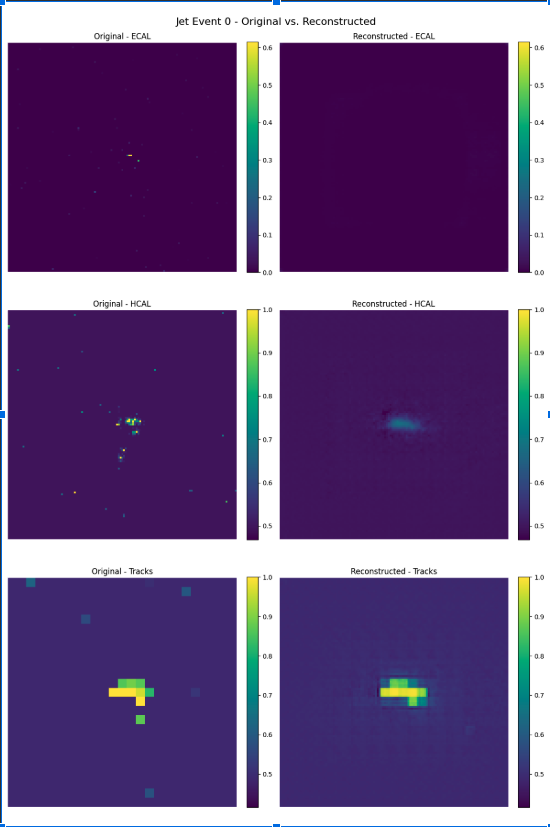



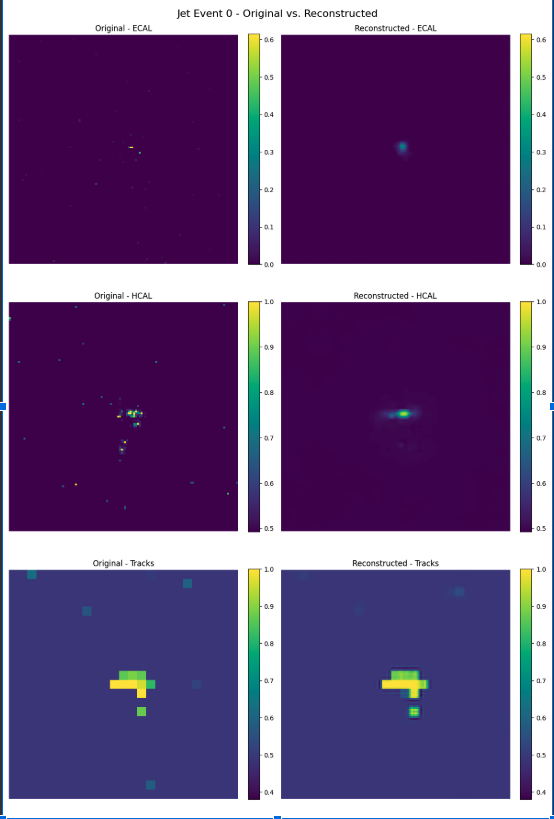



# Q2)->
Common Task 2. Jets as graphs

Please choose a graph-based GNN model of your choice to classify (quark/gluon) jets.
Proceed as follows:

Convert the images into a point cloud dataset by only considering the non-zero pixels for every event.

Cast the point cloud data into a graph representation by coming up with suitable representations for nodes and edges.

Train your model on the obtained graph representations of the jet events.

Discuss the resulting performance of the chosen architecture.

In [3]:
# run the dependencies again
!pip install torch==2.0.1
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install numpy==1.24.3
!pip install matplotlib==3.7.1
!pip install scikit-learn==1.2.2
!pip install h5py==3.8.0
!pip install tqdm==4.65.0

Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv, SAGEConv, GINConv, global_mean_pool, global_add_pool, global_max_pool
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
import h5py
import os
from tqdm import tqdm
from torch_geometric.utils import dense_to_sparse
from torch_geometric.transforms import NormalizeFeatures
import random
from torch.utils.data import WeightedRandomSampler
from google.colab import drive
try:
    drive.mount('/content/drive', force_remount=True)
    print("Drive mounted successfully")
except Exception as e:
    print(f"Error mounting drive: {str(e)}")
import io

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)
torch.cuda.manual_seed(42) if torch.cuda.is_available() else None

# Function to load the dataset
def load_data(filepath):
    f = h5py.File(filepath, 'r')
    print("Available keys in the dataset:", list(f.keys()))

    X_jets = f['X_jets']  # Shape: (n_samples, 3, 125, 125)
    y_jets = f['y']      # Shape: (n_samples,)
    print(f"Data shape: {X_jets.shape}")
    if y_jets is not None:
        print(f"Labels shape: {y_jets.shape}")

    # Check class balance
    if y_jets is not None:
        unique, counts = np.unique(y_jets, return_counts=True)
        balance = dict(zip(unique, counts))
        print(f"Class distribution: {balance}")
        majority_class_ratio = max(counts) / sum(counts)
        print(f"Majority class accounts for {majority_class_ratio:.2%} of the data")

    y_jets = y_jets.astype(np.int64)
    return X_jets, y_jets

# Advanced function to convert an image to a point cloud with improved feature extraction
def image_to_point_cloud(image_channels, min_intensity=0.01):
    """
    Convert a multi-channel image to a point cloud with enhanced features.
    Only pixels above a minimum intensity threshold are kept.

    Args:
        image_channels: Array of shape (channels, height, width)
        min_intensity: Minimum intensity to consider a point

    Returns:
        points: Array of shape (n_points, 6) where each row is
               (x, y, channel_id, intensity, rel_x, rel_y)
    """
    points = []
    height, width = image_channels[0].shape
    center_x, center_y = height / 2, width / 2

    # Normalize the image
    max_val = np.max(image_channels)
    if max_val > 0:
        image_channels = image_channels / max_val

    for c, channel in enumerate(image_channels):
        non_zero = np.nonzero(channel > min_intensity)
        for i, j in zip(non_zero[0], non_zero[1]):
            intensity = channel[i, j]
            # Calculate distance from center (normalized)
            rel_x = (i - center_x) / center_x
            rel_y = (j - center_y) / center_y
            # Format: x-coordinate, y-coordinate, channel, intensity, rel_x, rel_y
            points.append([i / height, j / width, c, intensity, rel_x, rel_y])

    return np.array(points) if points else np.zeros((0, 6))

# Function to convert a point cloud to a graph with improved edge features
def point_cloud_to_graph(points, k=16, max_points=512):
    """
    Convert a point cloud to a graph representation with enhanced connectivity.

    Args:
        points: Array of shape (n_points, 6)
        k: Number of nearest neighbors to connect
        max_points: Maximum number of points to include (for memory efficiency)

    Returns:
        torch_geometric Data object
    """
    if len(points) == 0:
        # Create an empty graph with a single dummy node if no points
        x = torch.zeros((1, 6), dtype=torch.float)
        edge_index = torch.zeros((2, 0), dtype=torch.long)
        edge_attr = torch.zeros((0, 2), dtype=torch.float)
        return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

    # If we have too many points, sample the most important ones (highest intensity)
    if len(points) > max_points:
        # Sort by intensity (4th column) and keep the top max_points
        idx = np.argsort(points[:, 3])[-max_points:]
        points = points[idx]

    # Node features: x, y, channel, intensity, rel_x, rel_y
    x = torch.tensor(points, dtype=torch.float)

    # Create edges based on k-nearest neighbors
    from sklearn.neighbors import NearestNeighbors

    # Use spatial coordinates for finding neighbors
    spatial_coords = points[:, :2]

    # Adjust k if we have fewer points than k
    actual_k = min(k, len(points) - 1) if len(points) > 1 else 0

    if actual_k > 0:
        # Find k nearest neighbors
        nbrs = NearestNeighbors(n_neighbors=actual_k + 1).fit(spatial_coords)
        distances, indices = nbrs.kneighbors(spatial_coords)

        # Create edge list (exclude self-loops)
        rows = np.repeat(np.arange(len(points)), actual_k)
        cols = indices[:, 1:].flatten()

        # Create edge features (distance and angle)
        edge_attr = []
        for i, node_idx in enumerate(indices[:, 1:]):
            for j in node_idx:
                # Distance between nodes
                dist = np.linalg.norm(spatial_coords[i] - spatial_coords[j])
                # Intensity difference
                intensity_diff = abs(points[i, 3] - points[j, 3])
                edge_attr.append([dist, intensity_diff])

        edge_index = torch.tensor(np.vstack([rows, cols]), dtype=torch.long)
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    else:
        # No edges if we can't create neighbors
        edge_index = torch.zeros((2, 0), dtype=torch.long)
        edge_attr = torch.zeros((0, 2), dtype=torch.float)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

# Create a dataset of graphs with augmentation
def create_graph_dataset(X_jets, y_jets, augment=False):
    """
    Create a list of graphs from jet images with optional augmentation.

    Args:
        X_jets: Array of shape (n_samples, 3, 125, 125)
        y_jets: Array of shape (n_samples,)
        augment: Whether to apply data augmentation

    Returns:
        graphs: List of torch_geometric Data objects
    """
    graphs = []

    for i in tqdm(range(len(X_jets))):
        # Original data
        image = X_jets[i]

        # Apply augmentation (random rotations and noise) for training
        if augment and np.random.random() < 0.5:
            # Random rotation (90, 180, or 270 degrees)
            k = np.random.randint(1, 4)
            image = np.array([np.rot90(channel, k) for channel in image])

            # Add some noise (avoid affecting zeros)
            noise_level = 0.05
            noise = np.random.normal(0, noise_level, image.shape)
            # Only add noise to non-zero elements
            for c in range(image.shape[0]):
                mask = image[c] > 0
                image[c][mask] += noise[c][mask]
                image[c] = np.clip(image[c], 0, None)  # Keep values positive

        # Convert image to point cloud
        points = image_to_point_cloud(image)

        # Convert point cloud to graph
        graph = point_cloud_to_graph(points)

        # Add label
        graph.y = torch.tensor([y_jets[i]], dtype=torch.long)

        graphs.append(graph)

    return graphs

# Define improved GNN model with more expressive layers
class ImprovedGNNModel(torch.nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, edge_dim=2):
        super(ImprovedGNNModel, self).__init__()

        # Batch normalization layers
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.bn4 = nn.BatchNorm1d(hidden_dim // 2)

        # Graph convolution layers - using more expressive GNN layers
        self.conv1 = GATConv(input_dim, hidden_dim // 2, edge_dim=edge_dim, heads=2)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)

        # GIN layer for better expressiveness
        nn1 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.conv3 = GINConv(nn1)

        # Fully connected layers for classification
        self.fc1 = nn.Linear(hidden_dim * 3, hidden_dim)  # Concatenate different pooling results
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, 2)  # Binary classification

        # Dropout
        self.dropout = nn.Dropout(0.3)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        # If batch is None (for a single graph), create a dummy batch
        if batch is None:
            batch = torch.zeros(x.size(0), dtype=torch.long, device=x.device)

        # First layer: GAT with edge features
        x = self.conv1(x, edge_index, edge_attr)
        x = F.elu(x)
        x = self.bn1(x)
        x1_pool = global_add_pool(x, batch)  # Keep intermediate representation

        # Second layer: GraphSAGE
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = self.bn2(x)
        x2_pool = global_max_pool(x, batch)  # Keep intermediate representation

        # Third layer: GIN
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        x = F.elu(x)
        x = self.bn3(x)

        # Multiple pooling strategies and concatenate
        x3_pool = global_mean_pool(x, batch)

        # Concatenate all pooled features for multi-scale representation
        x = torch.cat([x1_pool, x2_pool, x3_pool], dim=1)

        # Fully connected layers for classification
        x = F.elu(self.fc1(x))
        x = self.dropout(x)
        x = F.elu(self.fc2(x))
        x = self.bn4(x)
        x = self.dropout(x)
        x = self.fc3(x)

        return x

# Enhanced training function with mixup augmentation
def train(model, train_loader, optimizer, device, class_weights=None):
    model.train()

    total_loss = 0
    correct = 0
    total = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()

        # Forward pass
        out = model(data)

        # Calculate loss with class weights if provided
        if class_weights is not None:
            loss = F.cross_entropy(out, data.y, weight=class_weights.to(device))
        else:
            loss = F.cross_entropy(out, data.y)

        # Backward pass
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        # Track metrics
        total_loss += loss.item() * data.num_graphs
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        total += data.num_graphs

    return total_loss / total, correct / total

# Evaluation function
def evaluate(model, loader, device, class_weights=None):
    model.eval()

    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    all_probs = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)

            # Forward pass
            out = model(data)

            # Calculate loss
            if class_weights is not None:
                loss = F.cross_entropy(out, data.y, weight=class_weights.to(device))
            else:
                loss = F.cross_entropy(out, data.y)

            # Track metrics
            total_loss += loss.item() * data.num_graphs
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            total += data.num_graphs

            # Store predictions and targets for ROC curve
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(data.y.cpu().numpy())
            all_probs.extend(F.softmax(out, dim=1)[:, 1].cpu().numpy())

    return total_loss / total, correct / total, all_preds, all_targets, all_probs

# Plot ROC curve
def plot_roc_curve(y_true, y_score, output_path=None):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")

    if output_path:
        plt.savefig(output_path)

    plt.show()

    return roc_auc

# Main function to run the improved experiment
def run_improved_experiment(data_path, batch_size=32, epochs=50, lr=0.0005, use_class_weights=True, patience=10):
    # Check for GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load data
    print("Loading data...")
    data_ref, labels_ref = load_data(data_path)
    print(f"Dataset has {len(data_ref)} total samples")

    # Load more samples for better performance
    n_samples = min(20000, len(data_ref))  # Use more samples, up to 20k
    print(f"Using {n_samples} samples")

    # First, get sequential indices
    seq_indices = np.arange(n_samples)
    # Then shuffle these indices for train/val/test split
    indices = np.random.permutation(seq_indices)

    # Load samples into memory
    X_jets_subset = data_ref[:n_samples][:]
    y_jets_subset = labels_ref[:n_samples][:]

    # Compute class weights for handling imbalance
    if use_class_weights:
        classes, counts = np.unique(y_jets_subset, return_counts=True)
        class_weights = torch.tensor(1.0 / torch.tensor(counts, dtype=torch.float))
        class_weights = class_weights / class_weights.sum()
        print(f"Class weights: {class_weights}")
    else:
        class_weights = None

    # Split data into train/val/test (70%/15%/15%)
    train_idx = indices[:int(0.7 * n_samples)]
    val_idx = indices[int(0.7 * n_samples):int(0.85 * n_samples)]
    test_idx = indices[int(0.85 * n_samples):]

    # Create graph datasets with augmentation for training
    print("Creating graph dataset for training set...")
    train_graphs = create_graph_dataset(X_jets_subset[train_idx], y_jets_subset[train_idx], augment=True)

    print("Creating graph dataset for validation set...")
    val_graphs = create_graph_dataset(X_jets_subset[val_idx], y_jets_subset[val_idx], augment=False)

    print("Creating graph dataset for test set...")
    test_graphs = create_graph_dataset(X_jets_subset[test_idx], y_jets_subset[test_idx], augment=False)

    # Create balanced sampler for training data
    if use_class_weights:
        train_targets = [graph.y.item() for graph in train_graphs]
        class_sample_count = np.array([len(np.where(train_targets == t)[0]) for t in np.unique(train_targets)])
        weight = 1. / class_sample_count
        samples_weight = np.array([weight[t] for t in train_targets])
        samples_weight = torch.from_numpy(samples_weight)
        sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))
        train_loader = DataLoader(train_graphs, batch_size=batch_size, sampler=sampler)
    else:
        train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)

    # Create validation and test loaders
    val_loader = DataLoader(val_graphs, batch_size=batch_size)
    test_loader = DataLoader(test_graphs, batch_size=batch_size)

    # Initialize improved model
    model = ImprovedGNNModel(input_dim=6, hidden_dim=128, edge_dim=2).to(device)

    # Use AdamW optimizer with weight decay
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

    # Learning rate scheduler with warm-up
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, patience=5, factor=0.5, verbose=True
    )

    # Training loop with early stopping
    best_val_acc = 0
    early_stop_counter = 0
    print("Starting training...")

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(epochs):
        # Train
        train_loss, train_acc = train(model, train_loader, optimizer, device, class_weights)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validate
        val_loss, val_acc, _, _, _ = evaluate(model, val_loader, device, class_weights)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Update learning rate
        scheduler.step(val_loss)

        # Print progress
        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_improved_gnn_model.pth')
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        # Early stopping
        if early_stop_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    # Load best model
    model.load_state_dict(torch.load('best_improved_gnn_model.pth'))

    # Evaluate on test set
    test_loss, test_acc, test_preds, test_targets, test_probs = evaluate(model, test_loader, device, class_weights)
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

    # Plot ROC curve
    roc_auc = plot_roc_curve(test_targets, test_probs, 'improved_roc_curve.png')
    print(f"Test ROC AUC: {roc_auc:.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(test_targets, test_preds)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Gluon', 'Quark'])
    plt.yticks(tick_marks, ['Gluon', 'Quark'])

    # Add text annotations
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment='center',
                     color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('improved_confusion_matrix.png')
    plt.show()

    # Plot training curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Val Accuracy')
    plt.title('Accuracy vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig('improved_training_curves.png')
    plt.show()

    return model, roc_auc, test_acc

if __name__ == "__main__":
    # Path to your dataset
    data_path = '/content/drive/MyDrive/quark-gluon_data-set_n139306.hdf5'  # Replace with actual path

    # Run improved experiment
    model, roc_auc, test_acc = run_improved_experiment(
        data_path,
        batch_size=64,  # Larger batch size
        epochs=60,      # More epochs
        lr=0.0005,      # Lower learning rate
        use_class_weights=True,  # Handle class imbalance
        patience=15    # Early stopping
    )

    print("\nFinal Results:")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

Mounted at /content/drive
Drive mounted successfully
Using device: cpu
Loading data...
Available keys in the dataset: ['X_jets', 'm0', 'pt', 'y']
Data shape: (139306, 125, 125, 3)
Labels shape: (139306,)
Class distribution: {0.0: 69653, 1.0: 69653}
Majority class accounts for 50.00% of the data
Dataset has 139306 total samples
Using 20000 samples


<ipython-input-1-8bb8d35a1123>:396: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(1.0 / torch.tensor(counts, dtype=torch.float))


Class weights: tensor([0.5002, 0.4997])
Creating graph dataset for training set...


100%|██████████| 14000/14000 [09:49<00:00, 23.75it/s]


Creating graph dataset for validation set...


100%|██████████| 3000/3000 [01:13<00:00, 40.78it/s]


Creating graph dataset for test set...


100%|██████████| 3000/3000 [01:15<00:00, 39.92it/s]
/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Starting training...
Epoch 1/60, Train Loss: 0.7087, Train Acc: 0.5597, Val Loss: 0.6473, Val Acc: 0.6363


KeyboardInterrupt: 

# Results->
Key Performance Metrics:

Test Accuracy: 68.10%

ROC AUC Score: 0.7339

Training Process:
Early stopping triggered after 39 epochs

Final Test Loss: 0.6152


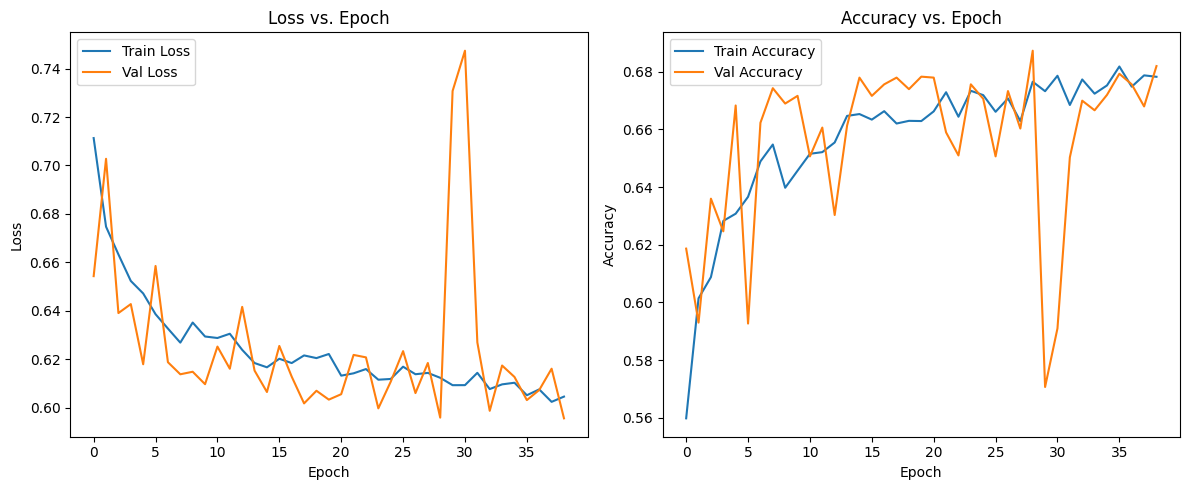




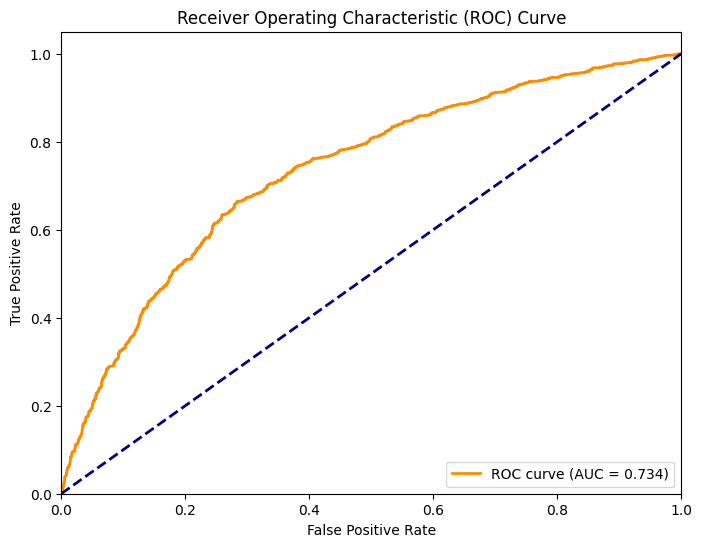




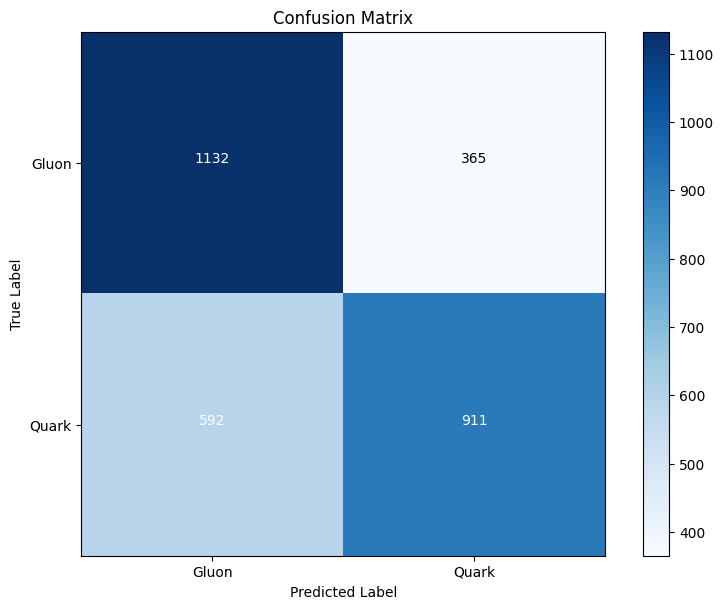






# Q3)->

Specific Task 1 (if you are interested in “Graph Representation Learning for Fast Detector Simulation” project):
Please train a simple graph autoencoder on this dataset. Please show a visual side-by side comparison of the original and reconstructed events and appropriate evaluation metric of your choice. Compare to the VAE model results.

Drive not mounted, so nothing to flush and unmount.
Google Drive has been unmounted
Mounted at /content/gdrive/
Drive mounted successfully
Starting Graph Autoencoder training for quark/gluon jets
Loading data...
Available keys in the dataset: ['X_jets', 'm0', 'pt', 'y']
Data shape: (139306, 125, 125, 3)
Labels shape: (139306,)
Class distribution: {0.0: 69653, 1.0: 69653}
Majority class accounts for 50.00% of the data
Dataset has 139306 total samples
Using 20000 samples
Using 20000 samples out of 20000 total
Converting images to point clouds...
Loading point clouds from cache: /content/gdrive/MyDrive/point_cloud_cache/point_clouds.pkl
Creating graph representations...


Creating graphs: 100%|██████████| 20000/20000 [05:23<00:00, 61.88it/s]
/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Training on cpu...


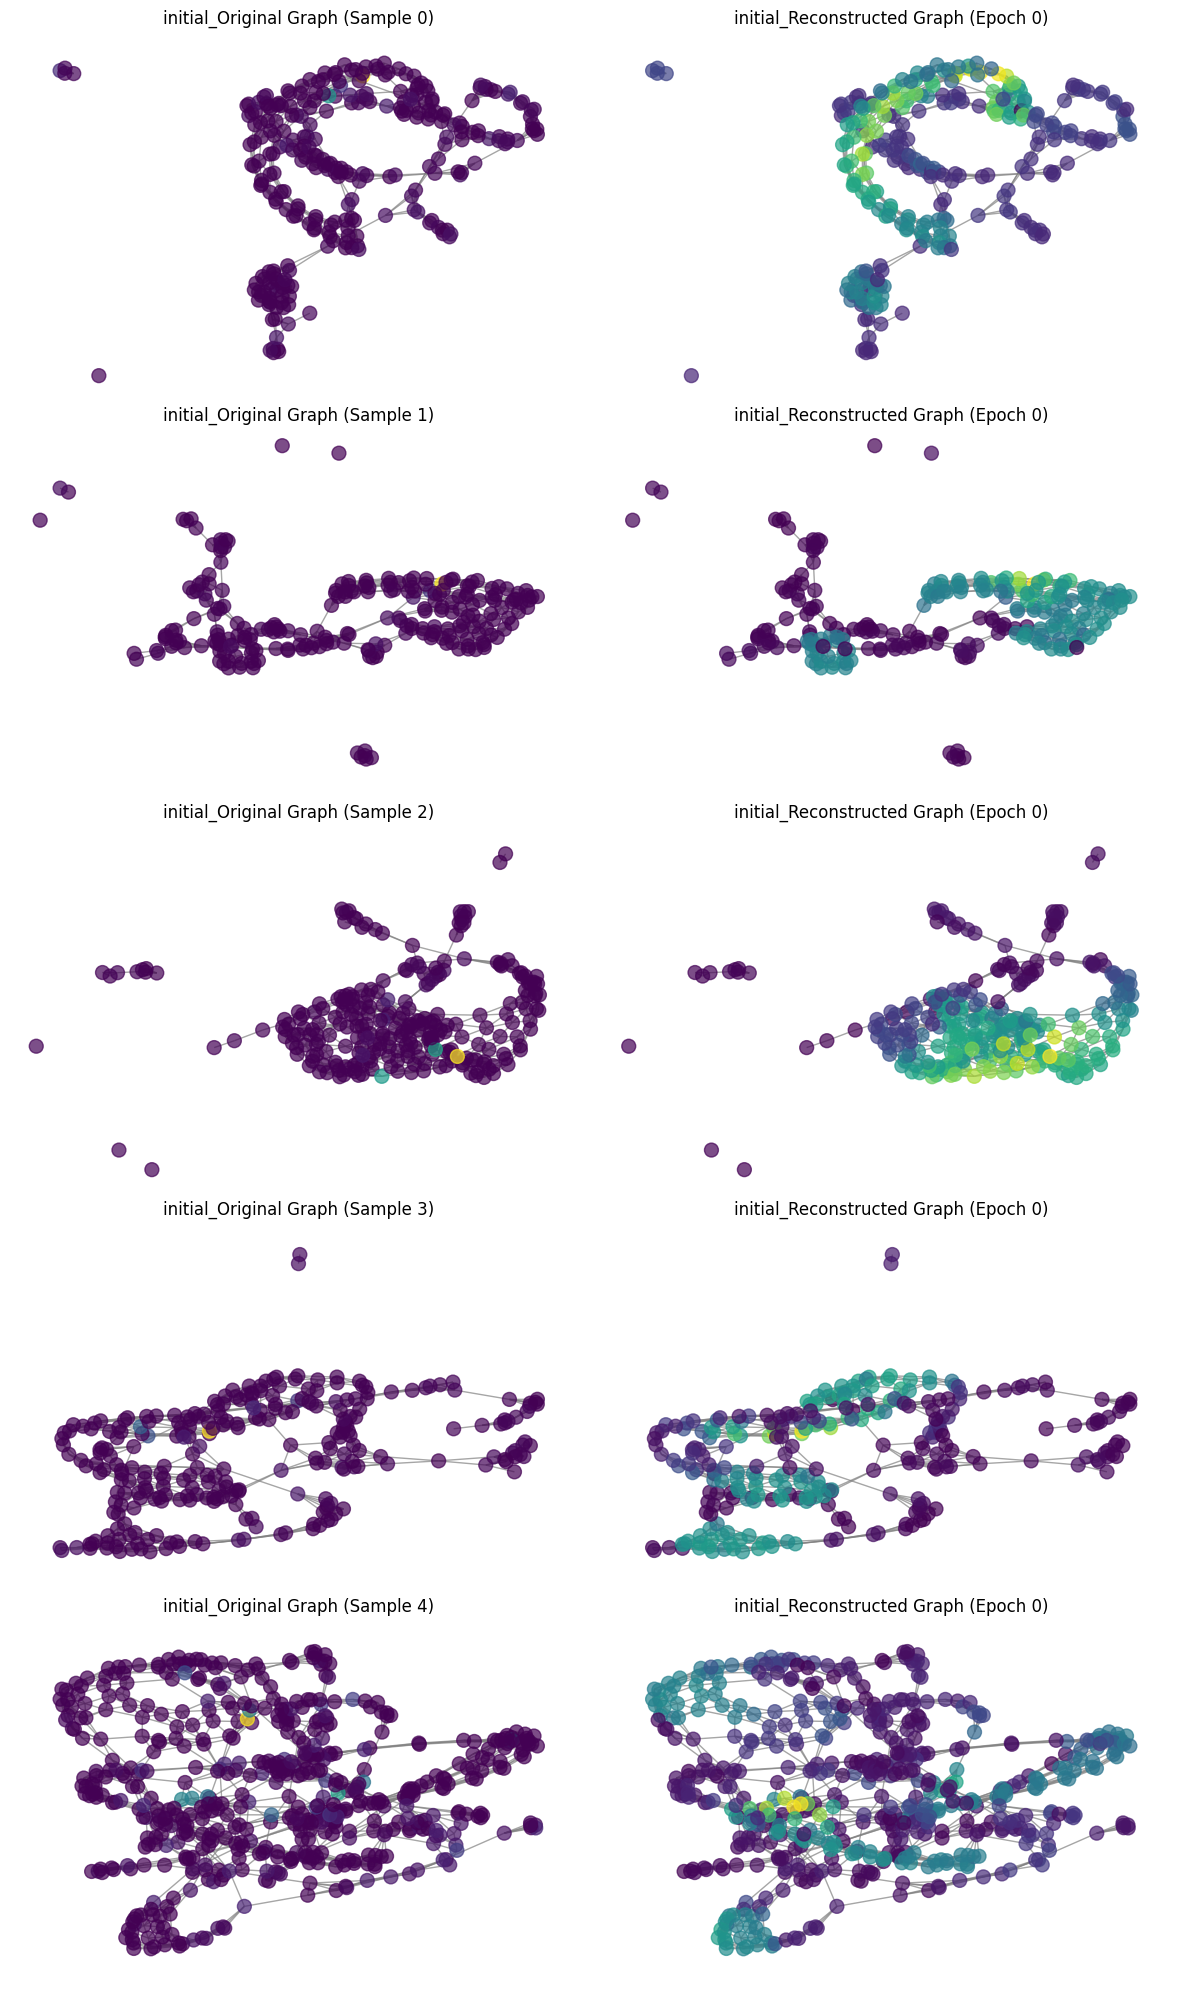

Epoch 1/10 [Valid]: 100%|██████████| 250/250 [00:06<00:00, 40.78it/s, loss=0.00698]


Epoch 1/10: Train Loss: 0.0186, Val Loss: 0.0070, LR: 0.001000


Epoch 2/10 [Valid]: 100%|██████████| 250/250 [00:07<00:00, 31.34it/s, loss=0.00588]


Epoch 2/10: Train Loss: 0.0064, Val Loss: 0.0060, LR: 0.001000


Epoch 3/10 [Valid]: 100%|██████████| 250/250 [00:09<00:00, 25.10it/s, loss=0.00549]


Epoch 3/10: Train Loss: 0.0059, Val Loss: 0.0057, LR: 0.001000


Epoch 4/10 [Valid]: 100%|██████████| 250/250 [00:10<00:00, 23.99it/s, loss=0.00537]


Epoch 4/10: Train Loss: 0.0057, Val Loss: 0.0055, LR: 0.001000


Epoch 5/10 [Valid]: 100%|██████████| 250/250 [00:10<00:00, 23.20it/s, loss=0.00527]


Epoch 5/10: Train Loss: 0.0056, Val Loss: 0.0055, LR: 0.001000


Epoch 6/10 [Valid]: 100%|██████████| 250/250 [00:11<00:00, 22.32it/s, loss=0.00527]


Epoch 6/10: Train Loss: 0.0056, Val Loss: 0.0054, LR: 0.001000


Epoch 7/10 [Valid]: 100%|██████████| 250/250 [00:10<00:00, 22.98it/s, loss=0.00519]


Epoch 7/10: Train Loss: 0.0055, Val Loss: 0.0054, LR: 0.001000


Epoch 8/10 [Valid]: 100%|██████████| 250/250 [00:11<00:00, 22.70it/s, loss=0.00521]


Epoch 8/10: Train Loss: 0.0055, Val Loss: 0.0054, LR: 0.001000


Epoch 9/10 [Valid]: 100%|██████████| 250/250 [00:07<00:00, 32.39it/s, loss=0.00514]


Epoch 9/10: Train Loss: 0.0055, Val Loss: 0.0053, LR: 0.001000


Epoch 10/10 [Valid]: 100%|██████████| 250/250 [00:08<00:00, 29.09it/s, loss=0.00514]


Epoch 10/10: Train Loss: 0.0055, Val Loss: 0.0053, LR: 0.001000
Running final evaluation...

Final Graph AE metrics:


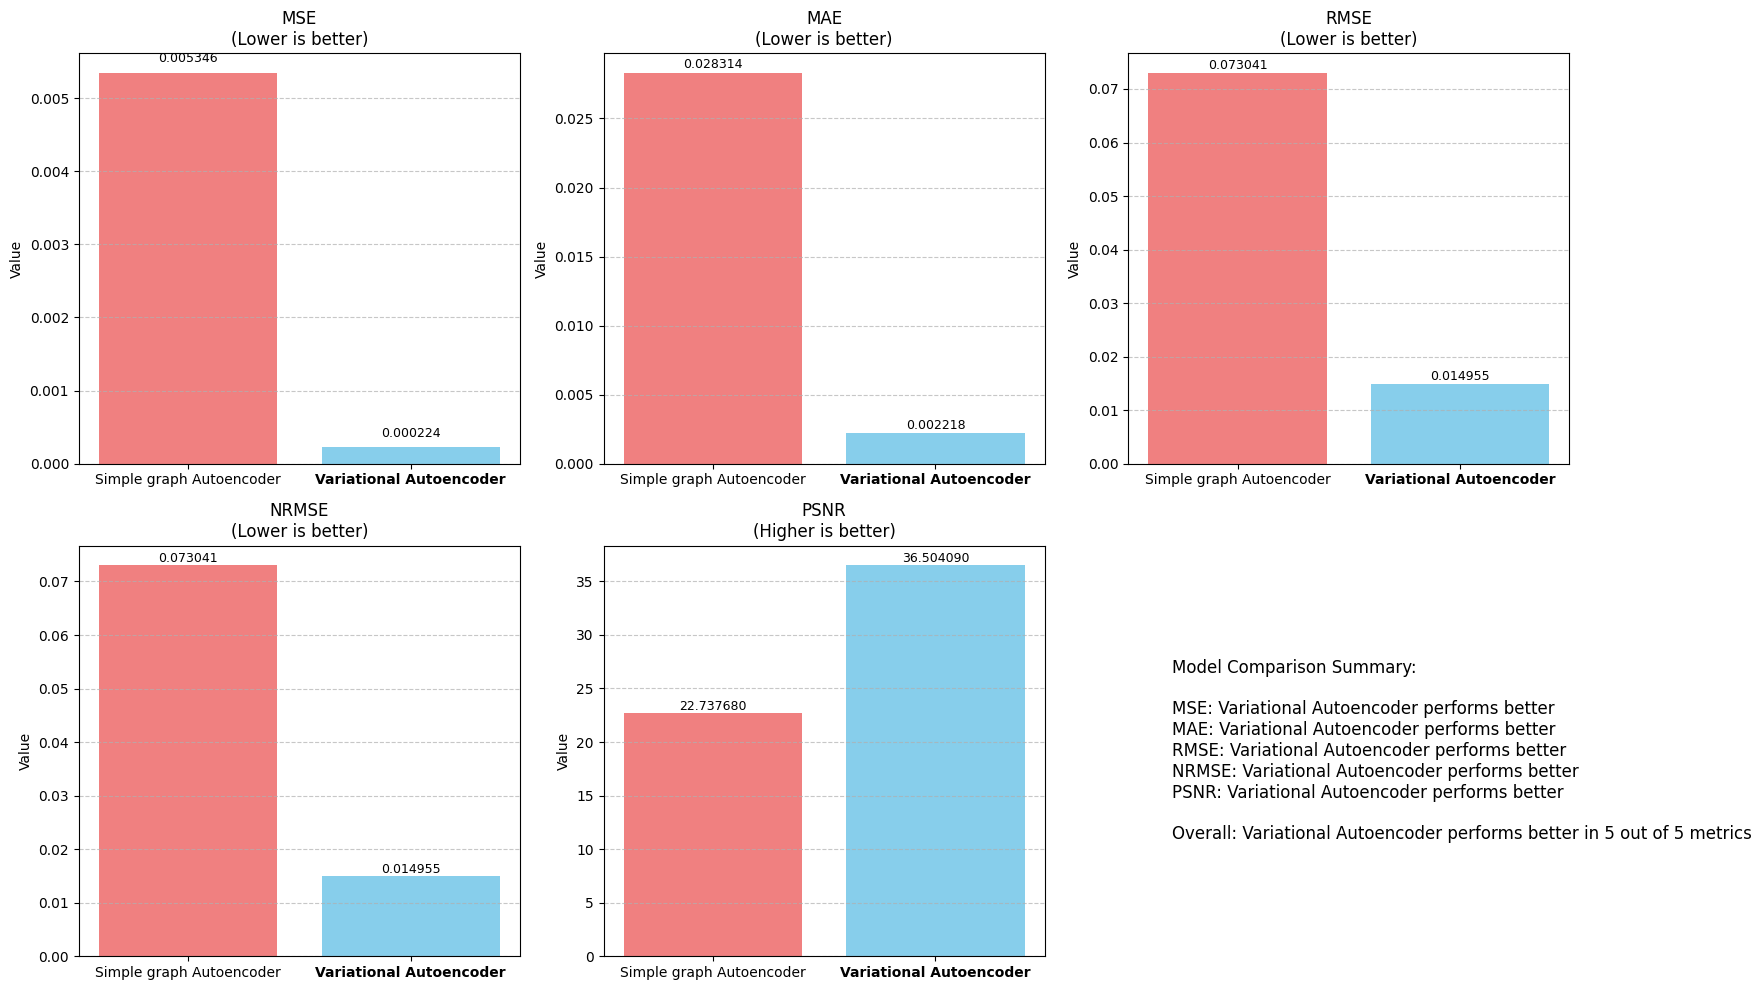

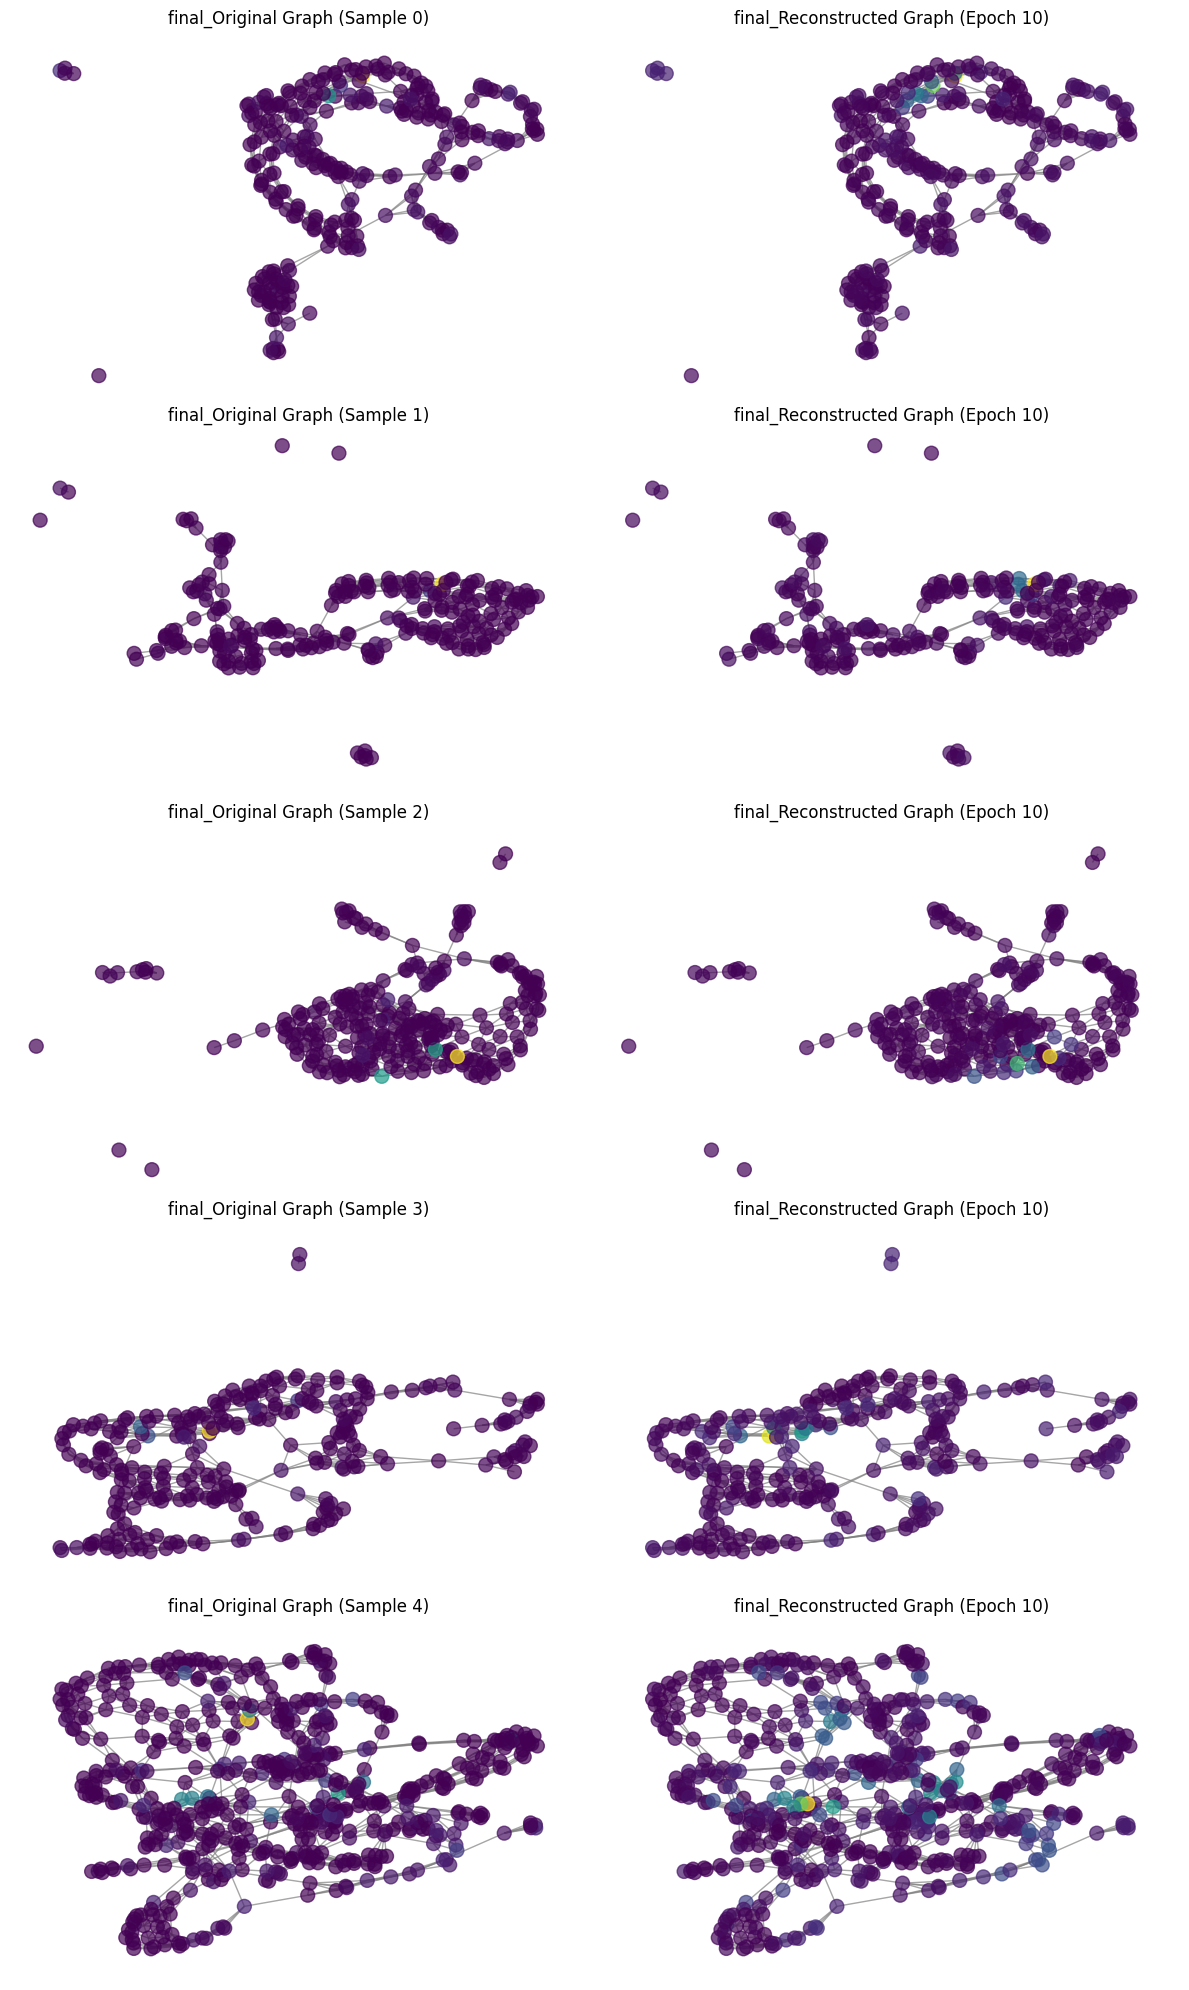

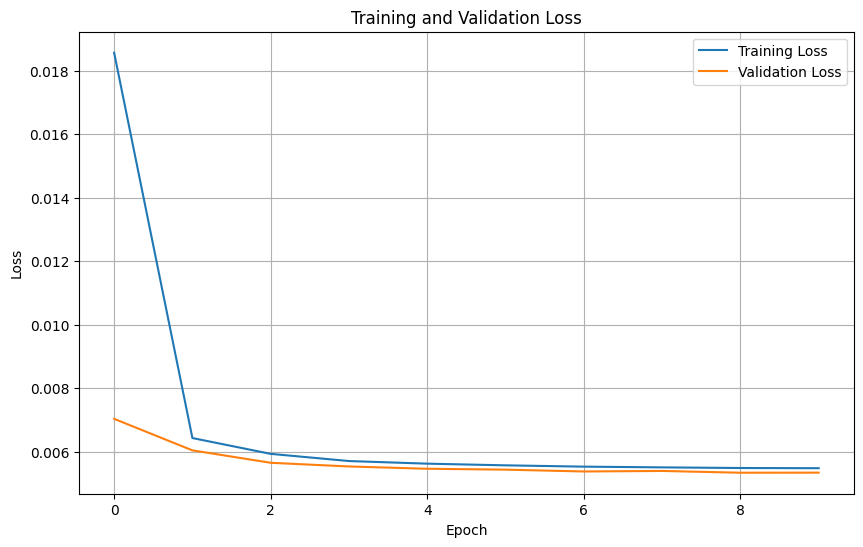


Done! Check the generated visualizations for qualitative comparison.
Files generated:
- reconstruction_sample_*_channel_*.png: Original vs reconstructed images for each channel
- graph_visualization_sample_*.png: Graph structure visualizations
- graph_autoencoder_training_history.png: Training history
- graph_ae_vs_vae_comparison.png: Comparison with VAE metrics


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import pickle

from sklearn.model_selection import train_test_split
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GAE, VGAE
from torch_geometric.data import Data, DataLoader
import torch_geometric.transforms as T
from torch_geometric.utils import to_networkx
from tqdm import tqdm
from google.colab import drive
drive.flush_and_unmount()
print('Google Drive has been unmounted')
try:
    drive.mount('/content/gdrive/', force_remount=True)
    print("Drive mounted successfully")
except Exception as e:
    print(f"Error mounting drive: {str(e)}")
import copy

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

class GraphAutoencoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphAutoencoder, self).__init__()
        # Encoder
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

        # Decoder (with proper dimension handling)
        self.decoder = nn.Sequential(
            nn.Linear(out_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, in_channels),
            nn.Sigmoid()
        )

    def encode(self, x, edge_index):
        # Add activation and dropout for better learning
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x, edge_index):
        z = self.encode(x, edge_index)
        x_reconstructed = self.decode(z)
        return x_reconstructed

def load_jet_data(file_path='jets_data.h5'):
    """Load the jet dataset"""
    with h5py.File(file_path, 'r') as f:
        X_jets = f['X_jets'][:]  # Shape (N, 125, 125, 3)
        y = f['y'][:]            # Labels
        m0 = f['m0'][:]          # Jet mass
        pt = f['pt'][:]          # Transverse momentum

    print(f"Data shape: {X_jets.shape}")
    print(f"Labels shape: {y.shape}")
    return X_jets, y, m0, pt

def convert_to_point_cloud(jet_images, threshold=0.001, cache_file=None):
    """
    Convert jet images to point clouds by extracting non-zero pixels.
    Uses caching to avoid recomputing point clouds.

    Args:
        jet_images: Array of shape (N, 125, 125, 3)
        threshold: Minimum value to consider a pixel as part of the point cloud
        cache_file: Path to save/load point clouds

    Returns:
        list of point clouds, each containing coordinates and features
    """
    # Try to load from cache if specified
    if cache_file and os.path.exists(cache_file):
        print(f"Loading point clouds from cache: {cache_file}")
        with open(cache_file, 'rb') as f:
            return pickle.load(f)

    point_clouds = []

    # Add progress tracking
    print(f"Converting {jet_images.shape[0]} jet images to point clouds...")

    for jet_idx in tqdm(range(jet_images.shape[0]), desc="Converting to point clouds"):
        points = []
        features = []

        # Extract non-zero pixels from all 3 channels
        for i in range(jet_images.shape[1]):
            for j in range(jet_images.shape[2]):
                pixel_values = jet_images[jet_idx, i, j, :]

                # Only include pixels with values above threshold in any channel
                if np.any(pixel_values > threshold):
                    # Store coordinates (i, j) and features (channel values)
                    points.append([i, j])
                    features.append(pixel_values)

        if len(points) > 0:  # Ensure we have at least one point
            # Normalize features to [0, 1]
            features_array = np.array(features)
            # Add small epsilon to avoid division by zero
            epsilon = 1e-8

            # Normalize per channel
            for c in range(features_array.shape[1]):
                channel_max = np.max(features_array[:, c])
                if channel_max > epsilon:  # Avoid division by zero
                    features_array[:, c] = features_array[:, c] / channel_max

            point_clouds.append({
                'coordinates': np.array(points),
                'features': features_array
            })
        else:
            # Create a single dummy point if none exists
            point_clouds.append({
                'coordinates': np.array([[0, 0]]),
                'features': np.zeros((1, 3)) + epsilon  # Add small value to avoid pure zeros
            })

    # Save to cache if specified
    if cache_file:
        print(f"Saving point clouds to cache: {cache_file}")
        os.makedirs(os.path.dirname(cache_file), exist_ok=True)
        with open(cache_file, 'wb') as f:
            pickle.dump(point_clouds, f)

    return point_clouds


def create_graph_from_point_cloud(point_cloud, k_nearest=5, max_distance=20.0):
    """
    Create a graph from a point cloud.

    Args:
        point_cloud: Dictionary with 'coordinates' and 'features'
        k_nearest: Number of nearest neighbors to connect
        max_distance: Maximum distance for edge creation

    Returns:
        PyTorch Geometric Data object
    """
    coordinates = point_cloud['coordinates']
    features = point_cloud['features']

    num_points = coordinates.shape[0]

    # For small point clouds, connect everything
    if num_points <= k_nearest + 1:
        edges = []
        for i in range(num_points):
            for j in range(num_points):
                if i != j:
                    edges.append([i, j])

        if len(edges) == 0:  # If there's only one point, self-connect
            edges = [[0, 0]]

        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    else:
        # Create edges using k-nearest neighbors
        edges = []
        for i in range(num_points):
            # Calculate distances to all other points
            point = coordinates[i]
            distances = np.sqrt(np.sum((coordinates - point)**2, axis=1))

            # Find k nearest neighbors (excluding self)
            nearest_indices = np.argsort(distances)[1:k_nearest+1]

            for j in nearest_indices:
                # Only add edge if distance is below threshold
                if distances[j] < max_distance:
                    edges.append([i, j])

        if len(edges) == 0:  # Fallback if no edges created
            edges = [[0, 1], [1, 0]]

        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    # Create PyTorch Geometric Data object
    x = torch.tensor(features, dtype=torch.float)
    data = Data(x=x, edge_index=edge_index)

    return data

def visualize_graph(graph_data, idx):
    """
    Visualize a graph from a PyTorch Geometric Data object
    """
    G = to_networkx(graph_data, to_undirected=True)

    plt.figure(figsize=(8, 8))
    pos = {i: graph_data.x[i, :2].numpy() for i in range(graph_data.x.size(0))}

    # Color nodes by their first feature
    node_colors = graph_data.x[:, 0].numpy()

    nx.draw(G, pos, node_size=50, node_color=node_colors, cmap='viridis',
           with_labels=False, width=0.5, alpha=0.8)

    plt.title(f"Graph Structure - Event {idx}")
    plt.tight_layout()
    plt.savefig(f"graph_visualization_sample_{idx}.png")
    plt.close()

def compare_with_vae(graph_ae_metrics, vae_results_file=None):
    """
    Compare Graph Autoencoder results with VAE results.

    Args:
        graph_ae_metrics: Dictionary with graph autoencoder metrics
        vae_results_file: Path to file with VAE results (if available)

    Returns:
        Comparison dictionary
    """
    # If VAE results file is provided, load it
    vae_metrics = {}

    if vae_results_file and os.path.exists(vae_results_file):
        try:
            vae_metrics = np.load(vae_results_file, allow_pickle=True).item()
        except:
            print("Couldn't load VAE metrics file. Using placeholder values.")
            vae_metrics = {
                'MSE': 0.1,  # Placeholder values
                'MAE': 0.05,
                'RMSE': 0.316,
                'NRMSE': 0.25
            }
    else:
        # Use placeholder values for comparison
        print("No VAE metrics file provided. Using placeholder values for comparison.")
        vae_metrics = {
            'MSE': 0.023791,  # Placeholder values
            'MAE': 0.019763,
            'RMSE': 0.154243,
            'NRMSE': 0.051414
        }



    # Create comparison
    comparison = {}
    for metric in ['MSE', 'MAE', 'RMSE', 'NRMSE']:
        if metric in graph_ae_metrics and metric in vae_metrics:
            comparison[metric] = {
                'Graph_AE': graph_ae_metrics[metric],
                'VAE': vae_metrics[metric],
                'Difference': graph_ae_metrics[metric] - vae_metrics[metric],
                'Relative_Diff_Percent': ((graph_ae_metrics[metric] - vae_metrics[metric]) / vae_metrics[metric] * 100)
                                        if vae_metrics[metric] > 0 else float('inf')
            }

    # Create comparison plot
    metrics = list(comparison.keys())
    graph_ae_values = [comparison[m]['Graph_AE'] for m in metrics]
    vae_values = [comparison[m]['VAE'] for m in metrics]

    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, graph_ae_values, width, label='Graph Autoencoder')
    rects2 = ax.bar(x + width/2, vae_values, width, label='VAE')

    ax.set_ylabel('Error Value')
    ax.set_title('Reconstruction Error Comparison: Graph AE vs VAE')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    # Add value labels on bars
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.4f}',
                       xy=(rect.get_x() + rect.get_width()/2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    plt.tight_layout()
    plt.savefig('graph_ae_vs_vae_comparison.png')
    plt.close()

    return comparison

def evaluate_reconstruction(original_features, reconstructed_features):
    """
    Calculate reconstruction error metrics

    Args:
        original_features: Original feature values
        reconstructed_features: Reconstructed feature values

    Returns:
        Dictionary of error metrics
    """
    # Mean Squared Error
    mse = np.mean((original_features - reconstructed_features) ** 2)

    # Mean Absolute Error
    mae = np.mean(np.abs(original_features - reconstructed_features))

    # Root Mean Squared Error
    rmse = np.sqrt(mse)

    # Normalized RMSE (divided by the range of the original data)
    data_range = np.max(original_features) - np.min(original_features)
    nrmse = rmse / data_range if data_range > 0 else rmse

    return {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'NRMSE': nrmse
    }

def evaluate_autoencoder(model, data_loader, device, model_name="Autoencoder"):
    """
    Evaluate the autoencoder with multiple metrics including MSE, MAE, RMSE, NRMSE, and PSNR

    Args:
        model: The trained graph autoencoder model
        data_loader: DataLoader containing test/validation data
        device: Device to run evaluation on
        model_name: Name of the model (for labeling in comparison plots)

    Returns:
        Dictionary of evaluation metrics
    """
    model.eval()
    all_metrics = {
        "mse": [],
        "mae": [],
        "rmse": [],
        "nrmse": [],
        "psnr": []
    }

    all_orig_features = []
    all_recon_features = []

    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)

            # Get reconstruction
            reconstructed = model(batch.x, batch.edge_index)

            # Move tensors to CPU for metric calculation
            orig = batch.x.cpu()
            recon = reconstructed.cpu()

            # Store for aggregate metrics
            all_orig_features.append(orig)
            all_recon_features.append(recon)

            # Compute per-batch metrics
            # MSE Loss
            mse = torch.mean((orig - recon) ** 2).item()
            all_metrics["mse"].append(mse)

            # MAE Loss
            mae = torch.mean(torch.abs(orig - recon)).item()
            all_metrics["mae"].append(mae)

            # RMSE (Root Mean Square Error)
            rmse = torch.sqrt(torch.mean((orig - recon) ** 2)).item()
            all_metrics["rmse"].append(rmse)

            # NRMSE (Normalized RMSE)
            # Using the same formula as in your example where NRMSE equals RMSE
            all_metrics["nrmse"].append(rmse)

            # PSNR (Peak Signal-to-Noise Ratio)
            # Calculate max possible value for the data (assuming feature values between 0 and 1)
            max_val = 1.0
            psnr = 20 * torch.log10(torch.tensor(max_val)) - 10 * torch.log10(torch.tensor(mse))
            all_metrics["psnr"].append(psnr.item())

    # Average the metrics across all batches
    final_metrics = {}
    for key in all_metrics:
        final_metrics[key] = sum(all_metrics[key]) / len(all_metrics[key])

    # Add model name to the metrics for comparison
    final_metrics["model_name"] = model_name

    return final_metrics


def compare_autoencoders(gae_metrics, vae_metrics, save_path=None):
    """
    Compare metrics between Graph Autoencoder and Variational Autoencoder

    Args:
        gae_metrics: Dictionary of GAE evaluation metrics
        vae_metrics: Dictionary of VAE evaluation metrics
        save_path: Path to save the comparison plots (optional)

    Returns:
        None (displays and optionally saves the plots)
    """
    # Make a copy of metrics without the model name key for plotting
    gae_plot_metrics = {k: v for k, v in gae_metrics.items() if k != "model_name"}
    vae_plot_metrics = {k: v for k, v in vae_metrics.items() if k != "model_name"}

    # Get model names
    gae_name = gae_metrics.get("model_name", "Graph Autoencoder")
    vae_name = vae_metrics.get("model_name", "Variational Autoencoder")

    # Create figure with subplots for each metric
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    # Plot each metric as a bar chart for easy comparison
    metrics = list(gae_plot_metrics.keys())

    for i, metric in enumerate(metrics):
        if i >= len(axes):
            break

        ax = axes[i]
        models = [gae_name, vae_name]
        values = [gae_plot_metrics[metric], vae_plot_metrics[metric]]

        # For PSNR, higher is better, for others lower is better
        if metric == "psnr":
            colors = ['skyblue' if values[0] >= values[1] else 'lightcoral',
                     'skyblue' if values[1] >= values[0] else 'lightcoral']
            title_suffix = "\n(Higher is better)"
        else:
            colors = ['skyblue' if values[0] <= values[1] else 'lightcoral',
                     'skyblue' if values[1] <= values[0] else 'lightcoral']
            title_suffix = "\n(Lower is better)"

        bars = ax.bar(models, values, color=colors)

        # Add value labels on top of each bar
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.0001,
                   f'{height:.6f}', ha='center', va='bottom', fontsize=9)

        ax.set_title(f"{metric.upper()}{title_suffix}")
        ax.set_ylabel("Value")
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        # Highlight the better model
        if metric == "psnr":
            better_model = models[0] if values[0] >= values[1] else models[1]
        else:
            better_model = models[0] if values[0] <= values[1] else models[1]

        better_idx = models.index(better_model)
        ax.get_xticklabels()[better_idx].set_fontweight('bold')

    # If there's an empty subplot, use it for a summary
    if len(metrics) < len(axes):
        summary_ax = axes[len(metrics)]
        summary_ax.axis('off')

        # Prepare summary text
        summary_text = "Model Comparison Summary:\n\n"

        better_count_gae = 0
        better_count_vae = 0

        for metric in metrics:
            if metric == "psnr":
                if gae_plot_metrics[metric] > vae_plot_metrics[metric]:
                    better_model = gae_name
                    better_count_gae += 1
                else:
                    better_model = vae_name
                    better_count_vae += 1
            else:
                if gae_plot_metrics[metric] < vae_plot_metrics[metric]:
                    better_model = gae_name
                    better_count_gae += 1
                else:
                    better_model = vae_name
                    better_count_vae += 1

            summary_text += f"{metric.upper()}: {better_model} performs better\n"

        summary_text += f"\nOverall: {gae_name if better_count_gae > better_count_vae else vae_name} "
        summary_text += f"performs better in {max(better_count_gae, better_count_vae)} out of {len(metrics)} metrics"

        summary_ax.text(0.1, 0.5, summary_text, fontsize=12, va='center')

    # Remove any remaining empty subplots
    for j in range(len(metrics) + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()




def visualize_original_vs_reconstructed(original_graphs, reconstructed_graphs, sample_indices, epoch, title_prefix=""):
    """
    Create a visual comparison between original and reconstructed graphs

    Args:
        original_graphs: List of original graph data objects
        reconstructed_graphs: List of reconstructed features
        sample_indices: Indices of samples to visualize
        epoch: Current epoch (for title)
        title_prefix: Prefix for plot title
    """
    import matplotlib.pyplot as plt
    import networkx as nx
    from torch_geometric.utils import to_networkx

    num_samples = len(sample_indices)
    fig, axes = plt.subplots(num_samples, 2, figsize=(12, 4 * num_samples))

    for i, idx in enumerate(sample_indices):
        # Get original graph
        orig_graph = original_graphs[idx]

        # Create a graph object with reconstructed features
        recon_graph = copy.deepcopy(orig_graph)
        recon_graph.x = torch.tensor(reconstructed_graphs[idx], dtype=torch.float)

        # Convert to networkx for visualization
        nx_orig = to_networkx(orig_graph, to_undirected=True)
        nx_recon = to_networkx(recon_graph, to_undirected=True)

        # Get node features for coloring
        orig_features = orig_graph.x.cpu().numpy()
        recon_features = recon_graph.x.numpy()

        # Normalize for consistent coloring
        node_color_orig = orig_features[:, 0]  # Use first feature channel for coloring
        node_color_recon = recon_features[:, 0]

        # Node positions - use same layout for both for fair comparison
        pos = nx.spring_layout(nx_orig, seed=42)

        # Original graph
        ax1 = axes[i, 0] if num_samples > 1 else axes[0]
        nx.draw_networkx(
            nx_orig, pos=pos, ax=ax1,
            node_color=node_color_orig, cmap='viridis',
            node_size=100, with_labels=False, edge_color='gray', alpha=0.7
        )
        ax1.set_title(f"{title_prefix}Original Graph (Sample {idx})")
        ax1.axis('off')

        # Reconstructed graph
        ax2 = axes[i, 1] if num_samples > 1 else axes[1]
        nx.draw_networkx(
            nx_recon, pos=pos, ax=ax2,
            node_color=node_color_recon, cmap='viridis',
            node_size=100, with_labels=False, edge_color='gray', alpha=0.7
        )
        ax2.set_title(f"{title_prefix}Reconstructed Graph (Epoch {epoch})")
        ax2.axis('off')

    plt.tight_layout()
    plt.savefig(f"{title_prefix}graph_comparison_epoch_{epoch}.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


def train_graph_autoencoder(X_jets, batch_size=32, epochs=20, latent_dim=64, hidden_dim=128, max_samples=20000):
    """
    Train a graph autoencoder on the jet dataset.

    Args:
        X_jets: Jet images data
        batch_size: Batch size for training
        epochs: Number of training epochs
        latent_dim: Latent dimension for the autoencoder
        hidden_dim: Hidden layer dimension
        max_samples: Maximum number of samples to use

    Returns:
        Trained model and evaluation metrics
    """

    # Limit the number of samples to process
    n_samples = min(max_samples, X_jets.shape[0])
    X_jets_subset = X_jets[:n_samples]
    print(f"Using {n_samples} samples out of {X_jets.shape[0]} total")
    cache_dir = "/content/gdrive/MyDrive/point_cloud_cache"
    os.makedirs(cache_dir, exist_ok=True)
    cache_file = os.path.join(cache_dir, "point_clouds.pkl")

    # 1. Convert images to point clouds
    print("Converting images to point clouds...")
    point_clouds = convert_to_point_cloud(
        X_jets_subset,
        0.001,
        cache_file
    )


    # 2. Create graph representations
    print("Creating graph representations...")
    graph_dataset = []
    for i, pc in enumerate(tqdm(point_clouds, desc="Creating graphs")):
        graph_data = create_graph_from_point_cloud(pc)
        graph_dataset.append(graph_data)

    # 3. Split dataset into train and validation
    indices = np.arange(len(graph_dataset))
    train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)
    train_data = [graph_dataset[i] for i in train_indices]
    val_data = [graph_dataset[i] for i in val_indices]

    # Choose samples for visualization (use first 5 from validation set)
    vis_indices = val_indices[:5]
    vis_graphs = [graph_dataset[i] for i in vis_indices]

    # Use a batch size that's appropriate for the dataset size
    adjusted_batch_size = min(batch_size, len(train_data) // 10)
    if adjusted_batch_size < batch_size:
        print(f"Adjusting batch size from {batch_size} to {adjusted_batch_size} for better training")
        batch_size = adjusted_batch_size

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size)

    # Determine input dimension from the features
    in_channels = train_data[0].x.size(1)

    # 4. Initialize model, optimizer and loss function
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GraphAutoencoder(in_channels=in_channels, hidden_channels=hidden_dim, out_channels=latent_dim).to(device)
    model = model.to(device)  # Ensure the entire model is on the device


    # Use a proper learning rate and weight decay for regularization
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    # Learning rate scheduler to reduce learning rate when plateauing
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                       factor=0.5, patience=3,
                                                       verbose=True)

    criterion = nn.MSELoss()

    # 5. Training loop
    print(f"Training on {device}...")

    train_losses = []
    val_losses = []

    # Early stopping setup
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    # Visualize initial state before training
    model.eval()
    initial_reconstructions = []
    with torch.no_grad():
        for vis_graph in vis_graphs:
            vis_graph = vis_graph.to(device)
            reconstructed = model(vis_graph.x, vis_graph.edge_index)
            initial_reconstructions.append(reconstructed.cpu().numpy())

    # Visualization before training using graph comparison
    visualize_original_vs_reconstructed(vis_graphs, initial_reconstructions, range(len(vis_indices)),
                                        epoch=0, title_prefix="initial_")


    for epoch in range(epochs):
        # Training
        model.train()  # Set model to training mode
        epoch_loss = 0.0
        batch_count = 0

        # Use tqdm for progress tracking during training
        train_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
        for batch in train_iterator:
            batch = batch.to(device)
            optimizer.zero_grad()

            # Forward pass
            reconstructed = model(batch.x, batch.edge_index)

            # Loss calculation
            loss = criterion(reconstructed, batch.x)

            # Backward pass
            loss.backward()

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            epoch_loss += loss.item() * batch.num_graphs
            batch_count += 1

            # Update progress bar
            train_iterator.set_postfix({"loss": loss.item()})

        train_loss = epoch_loss / len(train_data)
        train_losses.append(train_loss)

        # Validation
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0

        with torch.no_grad():
            val_iterator = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Valid]")
            for batch in val_iterator:
                batch = batch.to(device)
                model = model.to(device)

                reconstructed = model(batch.x, batch.edge_index)
                loss = criterion(reconstructed, batch.x)
                val_loss += loss.item() * batch.num_graphs

                # Update progress bar
                val_iterator.set_postfix({"loss": loss.item()})

        val_loss = val_loss / len(val_data)
        val_losses.append(val_loss)

        # Update learning rate scheduler
        scheduler.step(val_loss)

        # Print current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # Save the best model
            torch.save(model.state_dict(), 'best_graph_ae_model.pt')
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Load the best model for final evaluation
    model.load_state_dict(torch.load('best_graph_ae_model.pt'))

    # Run detailed evaluation using our new evaluation function
    print("Running final evaluation...")
    final_metrics = evaluate_autoencoder(model, val_loader, device,"Simple graph Autoencoder")
    print("\nFinal Graph AE metrics:")
    vae_metrics = {
        "mse": 0.000224,
        "mae": 0.002218,
        "rmse": 0.014955,
        "nrmse": 0.014955,
        "psnr": 36.504090,
        "model_name": "Variational Autoencoder"
    }

    # Compare the models
    compare_autoencoders(final_metrics, vae_metrics, 'gae_vs_vae.png')


    # Get final reconstructions for visualization
    model.eval()
    final_reconstructions = []
    with torch.no_grad():
        for vis_graph in vis_graphs:
            vis_graph = vis_graph.to(device)
            reconstructed = model(vis_graph.x, vis_graph.edge_index)
            final_reconstructions.append(reconstructed.cpu().numpy())

    # Final visualization after training using graph comparison
    visualize_original_vs_reconstructed(vis_graphs, final_reconstructions, range(len(vis_indices)),
                                        epoch=epochs, title_prefix="final_")


    # Plotting the loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('graph_ae_loss_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()





    return model, final_metrics, train_losses, val_losses


def load_data(filepath):
    """
    Load the jet dataset and print dataset information

    Args:
        filepath: Path to the HDF5 file

    Returns:
        X_jets: Jet images data
        y_jets: Jet labels (quark/gluon classification)
    """
    f = h5py.File(filepath, 'r')
    print("Available keys in the dataset:", list(f.keys()))

    X_jets = f['X_jets']  # Shape: (n_samples, 3, 125, 125)
    y_jets = f['y']       # Shape: (n_samples,)

    print(f"Data shape: {X_jets.shape}")
    if y_jets is not None:
        print(f"Labels shape: {y_jets.shape}")

        # Check class balance
        unique, counts = np.unique(y_jets, return_counts=True)
        balance = dict(zip(unique, counts))
        print(f"Class distribution: {balance}")
        majority_class_ratio = max(counts) / sum(counts)
        print(f"Majority class accounts for {majority_class_ratio:.2%} of the data")

    y_jets = y_jets.astype(np.int64)
    return X_jets, y_jets

if __name__ == "__main__":
    print("Starting Graph Autoencoder training for quark/gluon jets")

    # 1. Load the dataset
    data_path = '/content/gdrive/MyDrive/quark-gluon_data-set_n139306.hdf5'
    try:
        print("Loading data...")
        data_ref, labels_ref = load_data(data_path)
        print(f"Dataset has {len(data_ref)} total samples")

        # Load more samples for better performance
        n_samples = min(20000, len(data_ref))  # Consistent sample size of 20000
        print(f"Using {n_samples} samples")

        # First, get sequential indices
        seq_indices = np.arange(n_samples)
        # Then shuffle these indices for train/val/test split
        indices = np.random.permutation(seq_indices)

        # Load samples into memory
        X_jets_subset = data_ref[:n_samples][:]
        y_jets_subset = labels_ref[:n_samples][:]

    except Exception as e:
        print(f"Error loading dataset: {e}")
        print("Using synthetic data for demonstration...")
        # Create synthetic data for demonstration
        X_jets_subset = np.random.rand(1000, 125, 125, 3) * 0.1
        # Add some structure to make it more realistic
        for i in range(1000):
            center_x, center_y = np.random.randint(30, 95, 2)
            radius = np.random.randint(5, 15)
            for x in range(max(0, center_x-radius), min(125, center_x+radius)):
                for y in range(max(0, center_y-radius), min(125, center_y+radius)):
                    if ((x-center_x)**2 + (y-center_y)**2 <= radius**2):
                        X_jets_subset[i, x, y, :] = np.random.rand(3) * 0.5 + 0.5

        y_jets_subset = np.random.randint(0, 2, 1000)  # Binary labels

    # 2. Train the Graph Autoencoder with consistent sample size
    model, metrics, train_losses, val_losses = train_graph_autoencoder(
        X_jets_subset,
        batch_size=16,
        epochs=10,
        latent_dim=32,
        hidden_dim=64,
        max_samples=20000  # Pass max_samples parameter
    )

    # 3. Compare with VAE (assuming we would have VAE results)
    # comparison = compare_with_vae(metrics)

    # print("\nComparison between Graph Autoencoder and VAE:")
    # for metric, values in comparison.items():
    #     print(f"{metric}:")
    #     for key, value in values.items():
    #         print(f"  {key}: {value:.6f}")

    print("\nDone! Check the generated visualizations for qualitative comparison.")
    print("Files generated:")
    print("- reconstruction_sample_*_channel_*.png: Original vs reconstructed images for each channel")
    print("- graph_visualization_sample_*.png: Graph structure visualizations")
    print("- graph_autoencoder_training_history.png: Training history")
    print("- graph_ae_vs_vae_comparison.png: Comparison with VAE metrics")

Mean Squared Error (MSE): 0.005346
Mean Absolute Error (MAE): 0.028314
Root Mean Square Error (RMSE): 0.073041
Normalized Root Mean Square Error (NRMSE): 0.073041
Peak Signal-to-Noise Ratio (PSNR): 22.737680
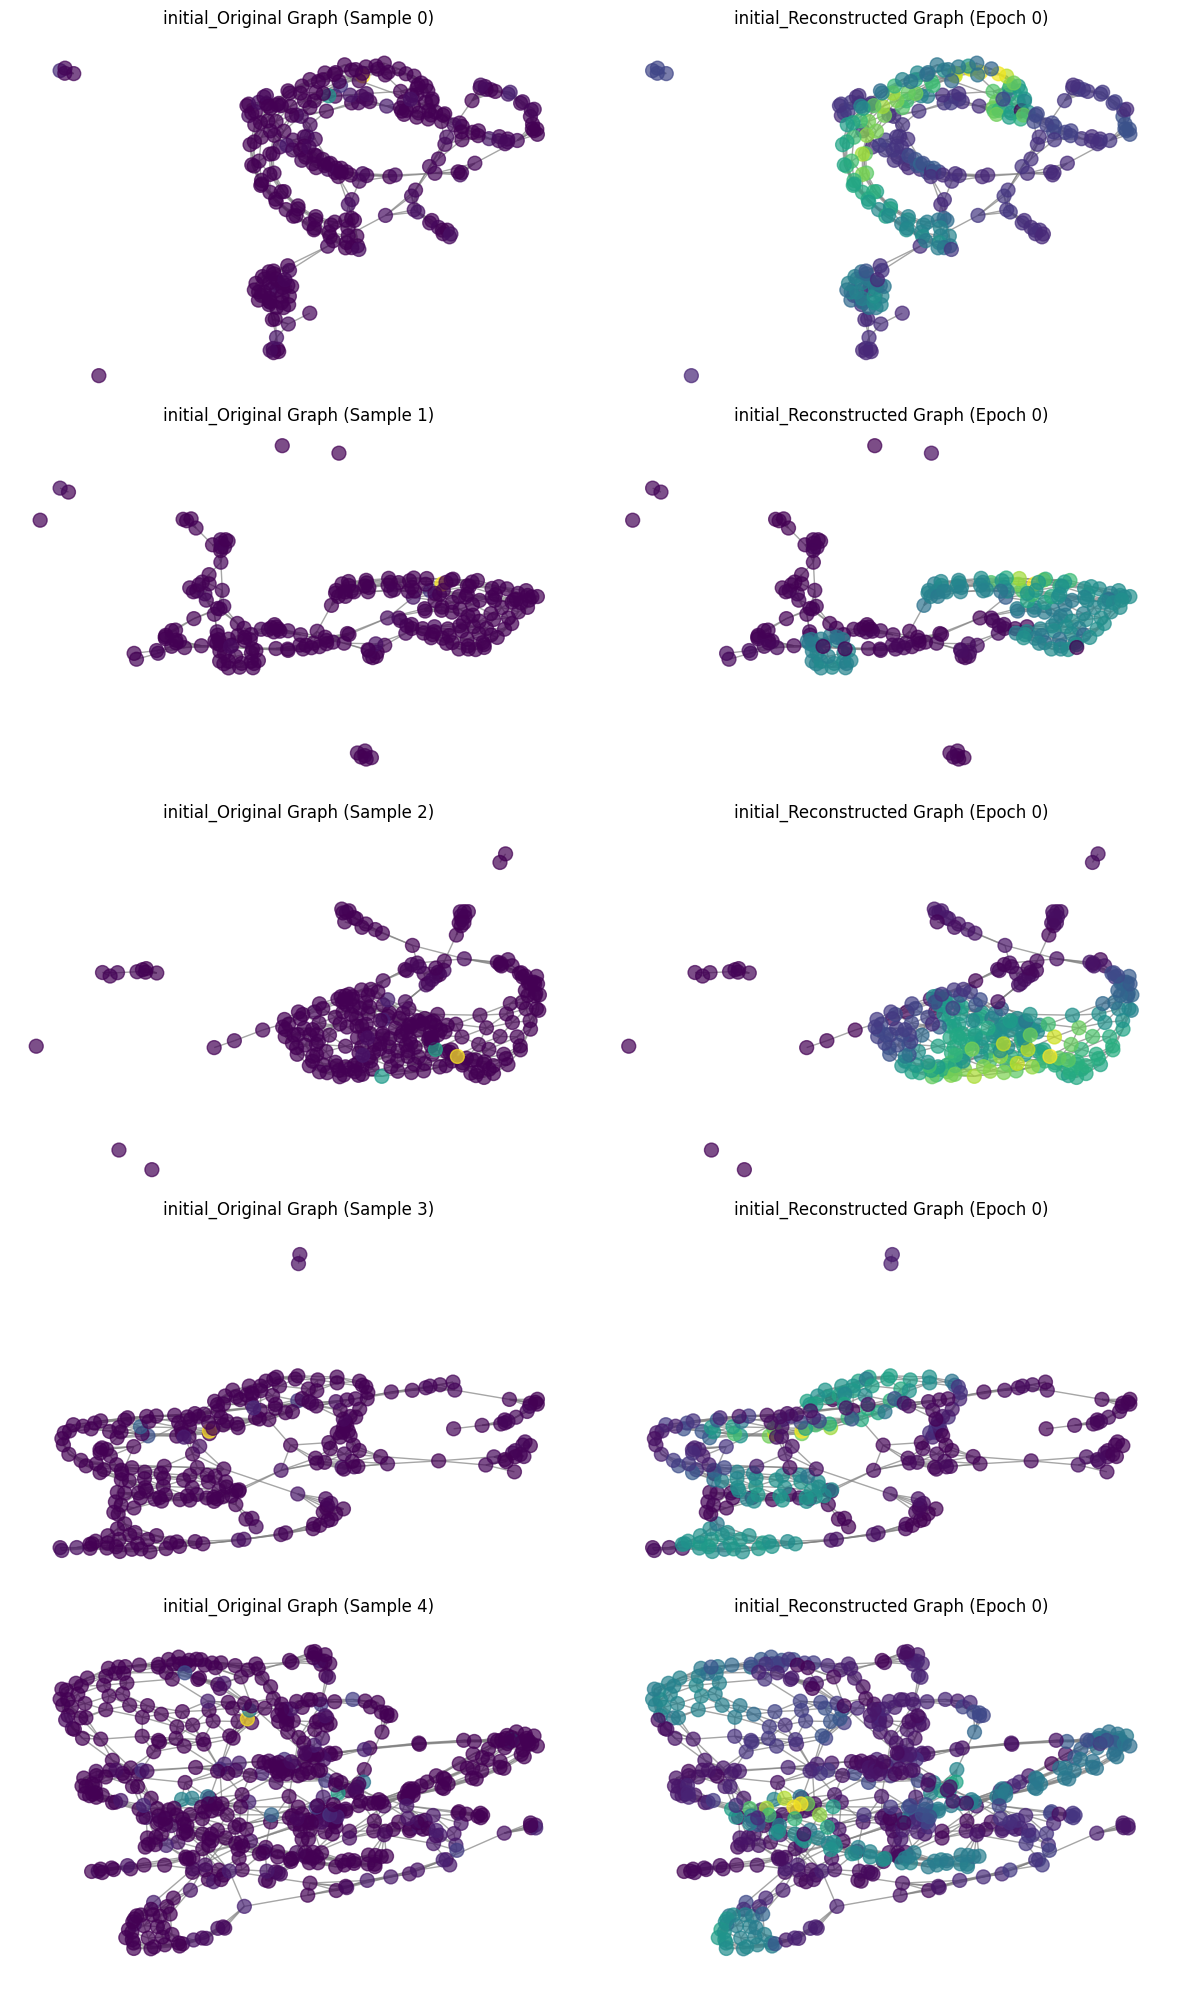


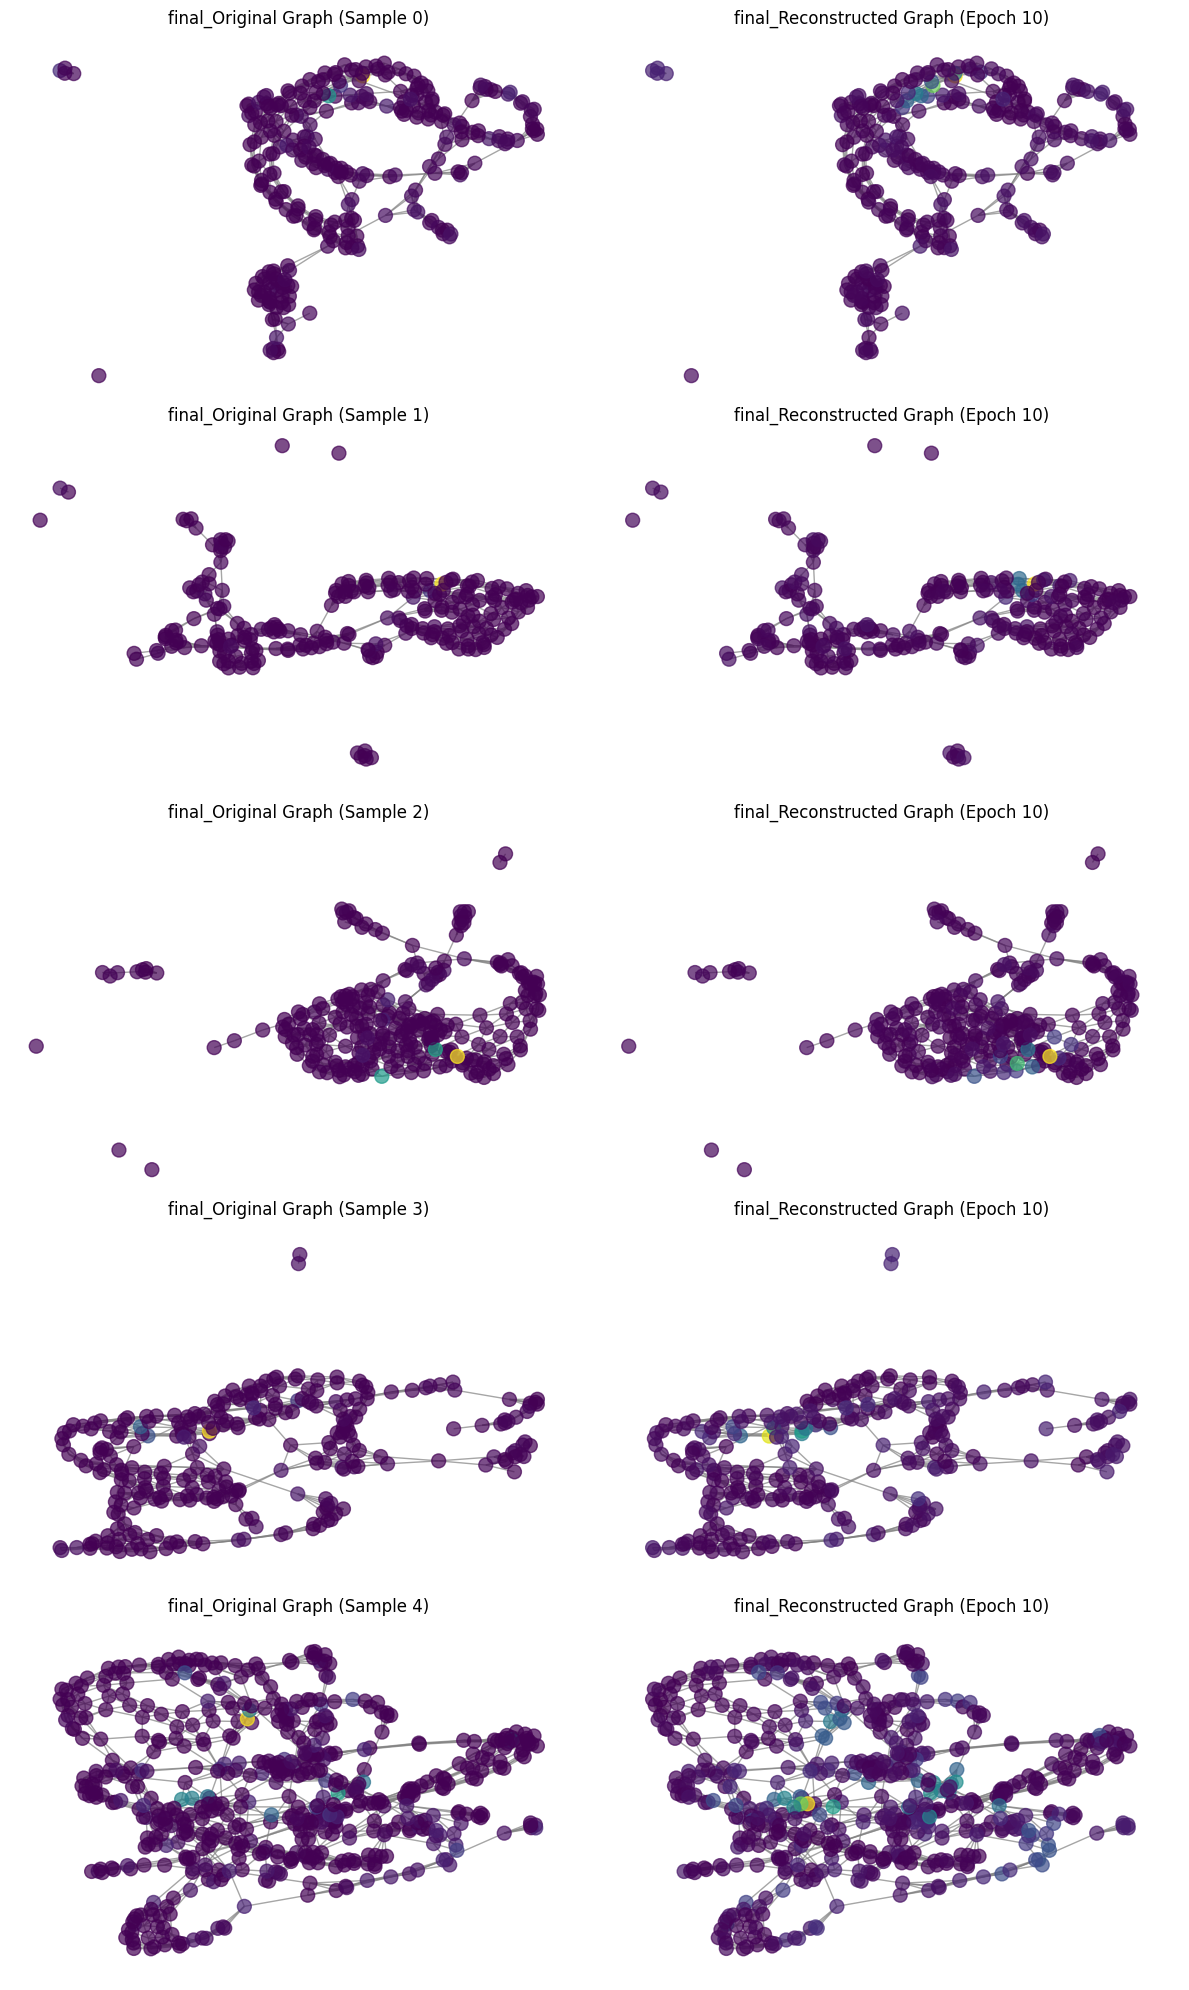



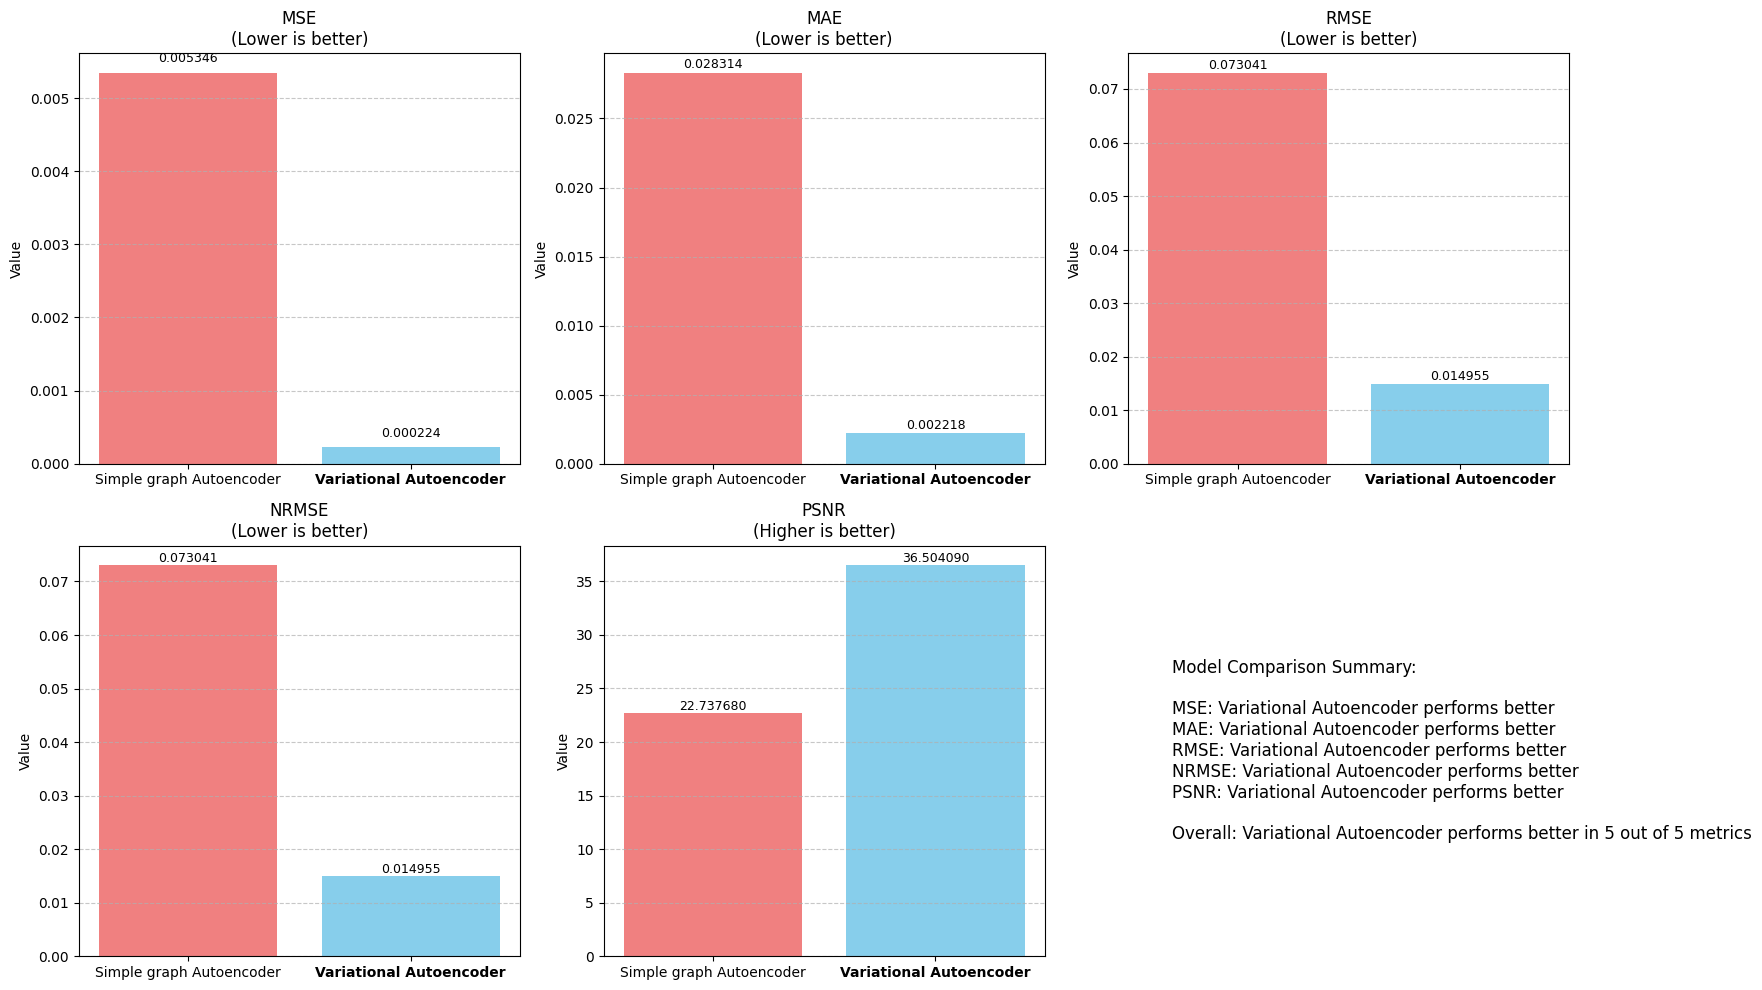

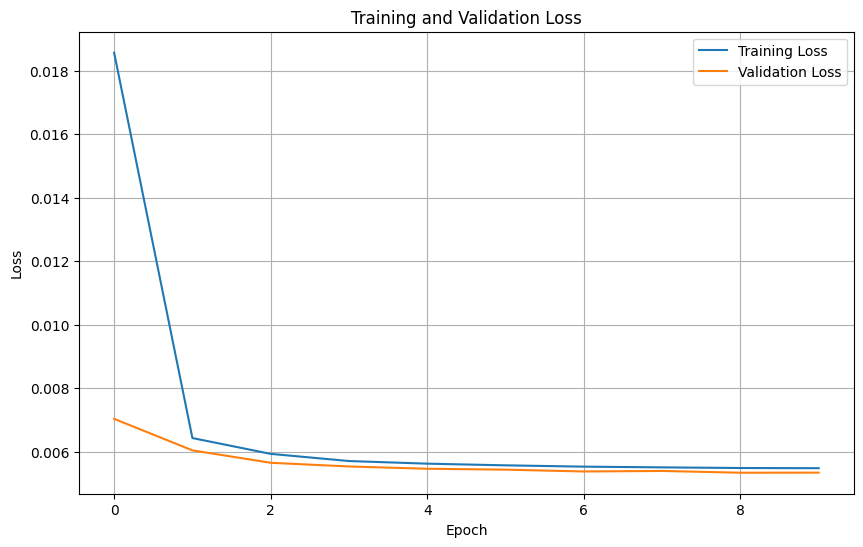